# LSTM Network

This notebook is preprocessing the NBA shot dataset to use it efficiently in the model building process, focussing on a LSTM neural network. After preprocessing, the most relevant features are selected and the hyperparameter are tuned.
The best model is built and tested on the test dataset of 2019-2023 and then on the 2015 season for better comparability to literature.

## Setup

Import necessary libraries and configure the environment for the data cleaning and preprocessing tasks.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Data Loading

Load the NBA shots data from CSV files for the years 2019 to 2023 and combine them into a single DataFrame.

In [3]:
years = [2019, 2020, 2021, 2022, 2023]

#years = [2019]
dfs = {'combined': pd.DataFrame()}  # Initialize a combined DataFrame

for year in years:
    file_path = f"data/NBA_{year}_Shots.csv"
    try:
        df = pd.read_csv(file_path)
        dfs[year] = df  # Store the DataFrame in the dictionary
        dfs['combined'] = pd.concat([dfs['combined'], df], ignore_index=True)  # Update the combined DataFrame
    except FileNotFoundError:
        print(f"The file 'NBA_{year}_Shots.csv' for {year} does not exist.")


# To select a specific year (e.g., 2020), you can access it like this:
df2019 = dfs[2019]
df2020 = dfs[2020]
df2021 = dfs[2021]
df2022 = dfs[2022]
df2023 = dfs[2023]

# To select the combined data, you can access it like this:
dfcombined = dfs['combined']

## Data Cleaning

Identify and handle missing values in the dataset to ensure data quality for analysis.


In [4]:
# Check for missing values in each column
missing_values = dfcombined.isnull().sum()

# Print columns with missing values and their respective counts
print(missing_values[missing_values > 0])

POSITION_GROUP    5305
POSITION          5305
dtype: int64


In [5]:
# Handling missing values: Check the percentage of missing values in 'POSITION_GROUP' and 'POSITION'
missing_values_percentage = dfcombined[['POSITION_GROUP', 'POSITION']].isnull().mean() * 100

# Handling duplicate rows: Check for any duplicate rows in the data
duplicate_rows = dfcombined.duplicated().sum()

# Output the percentage of missing values and the number of duplicate rows
(missing_values_percentage, duplicate_rows)

(POSITION_GROUP    0.513802
 POSITION          0.513802
 dtype: float64,
 60)

In [6]:
# Detect outliers using Z-score

# Outlier detection for 'LOC_X'
z_scores_loc_x = np.abs(stats.zscore(dfcombined['LOC_X']))
outliers_loc_x = np.where(z_scores_loc_x > 3)
print(f"There are {len(outliers_loc_x[0])} outliers in the 'LOC_X' column.")

# Outlier detection for 'LOC_Y'
z_scores_loc_y = np.abs(stats.zscore(dfcombined['LOC_Y']))
outliers_loc_y = np.where(z_scores_loc_y > 3)
print(f"There are {len(outliers_loc_y[0])} outliers in the 'LOC_Y' column.")

# Outlier detection for 'SHOT_DISTANCE'
z_scores_shot_distance = np.abs(stats.zscore(dfcombined['SHOT_DISTANCE']))
outliers_shot_distance = np.where(z_scores_shot_distance > 3)
print(f"There are {len(outliers_shot_distance[0])} outliers in the 'SHOT_DISTANCE' column.")

There are 45957 outliers in the 'LOC_X' column.
There are 8780 outliers in the 'LOC_Y' column.
There are 1749 outliers in the 'SHOT_DISTANCE' column.


C:\Users\ckollwitz\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


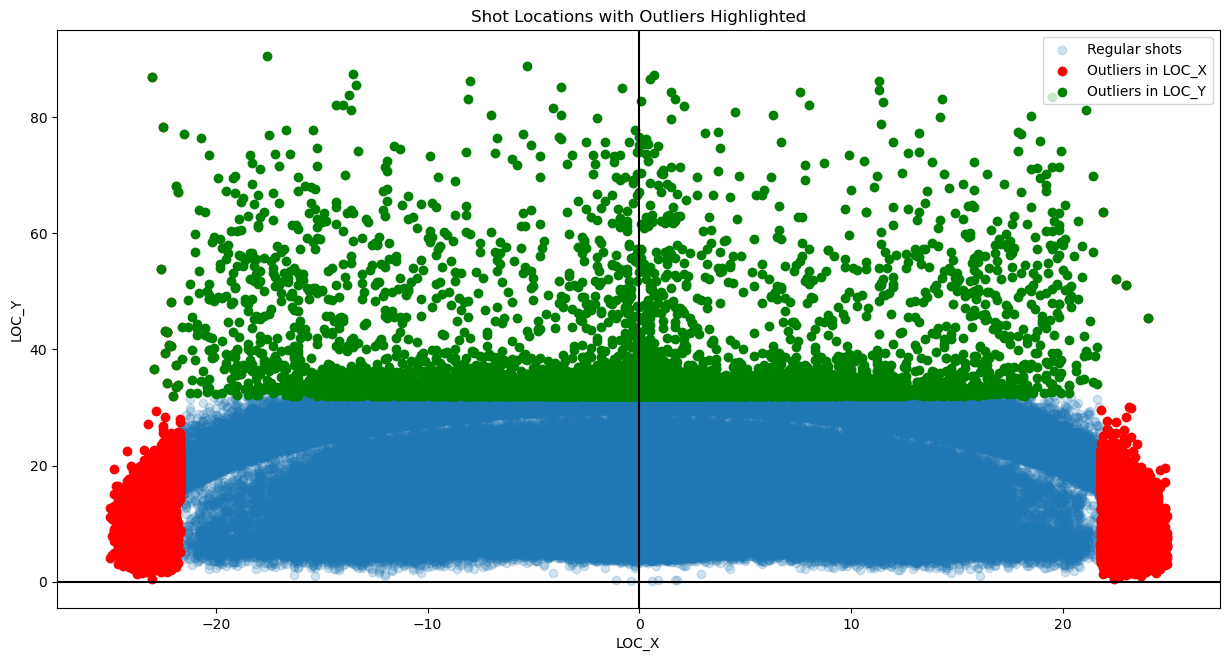

In [7]:
# Plotting LOC_X and LOC_Y to visualize shot locations
plt.figure(figsize=(15, 7.5))
# Plot a scatter plot of LOC_X and LOC_Y where the shots are made
plt.scatter(dfcombined['LOC_X'], dfcombined['LOC_Y'], alpha=0.2, label='Regular shots')
# Highlight the outliers
plt.scatter(dfcombined.loc[outliers_loc_x]['LOC_X'], dfcombined.loc[outliers_loc_x]['LOC_Y'], color='red', label='Outliers in LOC_X')
plt.scatter(dfcombined.loc[outliers_loc_y]['LOC_X'], dfcombined.loc[outliers_loc_y]['LOC_Y'], color='green', label='Outliers in LOC_Y')
plt.axhline(y=0, color='k')  # Add a line for the basket
plt.axvline(x=0, color='k')  # Center court line
plt.xlabel('LOC_X')
plt.ylabel('LOC_Y')
plt.title('Shot Locations with Outliers Highlighted')
plt.legend()
plt.show()

In [8]:
# Identify unique player names associated with each player ID
player_id_name = dfcombined.groupby('PLAYER_ID')['PLAYER_NAME'].unique()

# Identify player IDs with more than one associated name
inconsistent_players = player_id_name[player_id_name.apply(len) > 1]
print("Inconsistent Player IDs and names:")
print(inconsistent_players)

# Identify unique team names associated with each team ID
team_id_name = dfcombined.groupby('TEAM_ID')['TEAM_NAME'].unique()

# Identify team IDs with more than one associated name
inconsistent_teams = team_id_name[team_id_name.apply(len) > 1]
print("\nInconsistent Team IDs and names:")
print(inconsistent_teams)

Inconsistent Player IDs and names:
PLAYER_ID
1628384                   [O.G. Anunoby, OG Anunoby]
1628408                     [P.J. Dozier, PJ Dozier]
1630197    [Alekesej Pokusevski, Aleksej Pokusevski]
1630214         [Xavier Tillman Sr., Xavier Tillman]
1630288               [Jeff Dowtin, Jeff Dowtin Jr.]
1630527         [Brandon Boston, Brandon Boston Jr.]
Name: PLAYER_NAME, dtype: object

Inconsistent Team IDs and names:
TEAM_ID
1610612746    [LA Clippers, Los Angeles Clippers]
Name: TEAM_NAME, dtype: object


#### Analysis and Handling of Data Quality Issues
In the process of ensuring data quality for our NBA shots dataset, we have identified and addressed the following issues:

- Missing Values: The POSITION_GROUP and POSITION columns contain missing values, accounting for about 0.51% of the data. Due to the minimal impact, these rows have been removed.
- Duplicates: There are 60 instances of duplicate records. To maintain the dataset's integrity, these duplicates have been eliminated.
- Outliers: The LOC_X, LOC_Y, and SHOT_DISTANCE columns contain outliers. However, these values fall within the expected range of a basketball court and represent valid shot attempts, including less common long-range shots. Therefore, these outliers have been retained as they are crucial for a realistic representation of shot distribution.
- Inconsistent Player Names: The PLAYER ID and TEAM_ID columns had different ways of representing the same name

In [9]:
# Drop the duplicate rows
dfcombined_cleaned = dfcombined.drop_duplicates()

# Since the percentage of missing values is small, we will drop the rows with missing 'POSITION_GROUP' and 'POSITION'
dfcombined_cleaned = dfcombined_cleaned.dropna(subset=['POSITION_GROUP', 'POSITION'])

# Corrections for player names
player_name_corrections = {
    1630197: "Aleksej Pokusevski",
    1630527: "Brandon Boston Jr.",
    1628408: "PJ Dozier",
    1628384: "OG Anunoby",
    1630214: "Xavier Tillman Sr.",
    1630288: "Jeff Dowtin Jr."
}

# Apply the corrections for player names
dfcombined_cleaned['PLAYER_NAME'] = dfcombined_cleaned.apply(lambda row: player_name_corrections[row['PLAYER_ID']] if row['PLAYER_ID'] in player_name_corrections else row['PLAYER_NAME'], axis=1)

# Corrections for team names
team_name_corrections = {
    "LA Clippers": "Los Angeles Clippers"
}

# Apply the corrections for team names
dfcombined_cleaned['TEAM_NAME'] = dfcombined_cleaned['TEAM_NAME'].replace(team_name_corrections)

# Verify player name corrections
print("Corrected Player IDs and names:")
print(df.groupby('PLAYER_ID')['PLAYER_NAME'].unique())

# Verify team name corrections
print("\nCorrected Team IDs and names:")
print(df.groupby('TEAM_ID')['TEAM_NAME'].unique())

# Check if the cleaning was successful
cleaning_check = {
    "Remaining duplicates": dfcombined_cleaned.duplicated().sum(),
    "Remaining missing values": dfcombined_cleaned[['POSITION_GROUP', 'POSITION']].isnull().sum()
}

cleaning_check

Corrected Player IDs and names:
PLAYER_ID
2544             [LeBron James]
2617            [Udonis Haslem]
2738           [Andre Iguodala]
101108             [Chris Paul]
200752               [Rudy Gay]
                   ...         
1631323     [Simone Fontecchio]
1631367         [Jacob Gilyard]
1631466    [Jeenathan Williams]
1631495      [Donovan Williams]
1641645          [Xavier Cooks]
Name: PLAYER_NAME, Length: 537, dtype: object

Corrected Team IDs and names:
TEAM_ID
1610612737             [Atlanta Hawks]
1610612738            [Boston Celtics]
1610612739       [Cleveland Cavaliers]
1610612740      [New Orleans Pelicans]
1610612741             [Chicago Bulls]
1610612742          [Dallas Mavericks]
1610612743            [Denver Nuggets]
1610612744     [Golden State Warriors]
1610612745           [Houston Rockets]
1610612746               [LA Clippers]
1610612747        [Los Angeles Lakers]
1610612748                [Miami Heat]
1610612749           [Milwaukee Bucks]
1610612750    

{'Remaining duplicates': 0,
 'Remaining missing values': POSITION_GROUP    0
 POSITION          0
 dtype: int64}

## Data Preprocessing

##### Feature Description

Before transforming our features to be suitable for machine learning algorithms, let's summarize the characteristics of our numeric and categorical variables post-cleaning:

###### **Numeric Variables**
- There are 1,027,134 entries after cleaning.
- The SEASON_1 column, which seems to represent the year, ranges from 2019 to 2023.
- The SHOT_DISTANCE ranges from 0 to 88 feet, with a mean of approximately 13.5 feet.
- LOC_X and LOC_Y seem to represent the coordinates of the shot, with means close to 0, indicating that shots are spread around the basket.
- QUARTER ranges from 1 to 8, which may include overtime quarters.
- MINS_LEFT and SECS_LEFT show the time left in the quarter when the shot was taken.
###### **Categorical Variables**
- The dataset spans 5 seasons (SEASON_2), with '2018-19' being the most frequent season represented.
- TEAM_NAME and PLAYER_NAME have 31 and 948 unique entries, respectively, indicating the teams and players involved in the shots.
- Most shots were taken by guards (POSITION_GROUP) and specifically shooting guards (POSITION).
- The most common EVENT_TYPE is 'Missed Shot', which corresponds with the SHOT_MADE boolean column where False (missed shot) is more common than True (made shot).
- ACTION_TYPE has 48 unique types with 'Jump Shot' being the most common.
- The SHOT_TYPE indicates whether it was a 2-point or 3-point field goal.
- The BASIC_ZONE, ZONE_NAME, and ZONE_ABB columns describe the court area from which the shot was taken, with 'Restricted Area' and 'Center' being the most common zones.
- The ZONE_RANGE describes the distance category of the shot, with 'Less Than 8 ft.' being the most frequent.

#### Feature Transformation & Engineering

In this section, we map the categorical identifiers such as team IDs, player IDs, and zone abbreviations to their respective names for better interpretability. Additionally, we create a binary `IS_HOME_TEAM` column to indicate whether the team is playing at home, which simplifies the feature and reduces memory usage for future processing. This step is crucial for preparing the dataset for machine learning models, as it converts textual categorical data into a numerical format that can be easily processed by algorithms.

In [10]:
# Mapping Players & Teams with their IDs and zone names with its abbreviaton 

# Extract unique team IDs
unique_team_ids = dfcombined_cleaned['TEAM_ID'].unique()

# Extract unique team names
unique_team_names = dfcombined_cleaned['TEAM_NAME'].unique()

# Extract unique team abbreviations from the 'HOME_TEAM' column
unique_home_teams = dfcombined_cleaned['HOME_TEAM'].unique()

# Extract unique player IDs
unique_player_ids = dfcombined_cleaned['PLAYER_ID'].unique()

# Extract unique player names
unique_player_names = dfcombined_cleaned['PLAYER_NAME'].unique()

# Extract unique zone names
unique_zone_names = dfcombined_cleaned['ZONE_NAME'].unique()

# Extract unique zone abbreviations
unique_zone_abb = dfcombined_cleaned['ZONE_ABB'].unique()

In [11]:
# Creating a Is_Home_Team binary column in order to not double count the home/away feature and making it a numerical to save 
# memory + easier for future usage

# Mapping dictionaries to convert team, player identifiers and zone names to names and abbreviations.
team_id_to_name_mapping = dict(zip(unique_team_ids, unique_team_names))
team_abbreviation_to_id_mapping = dict(zip(unique_home_teams, unique_team_ids))
player_id_to_name_mapping = dict(zip(unique_player_ids, unique_player_names))
zone_abb_to_zonename_mapping = dict(zip(unique_zone_abb, unique_zone_names))

# Mapping team abbreviations to numeric team IDs for the 'HOME_TEAM' column.
team_abbr_to_id = {
    'LAC': 1610612762, 'ATL': 1610612746, 'MIL': 1610612737,
    'BKN': 1610612754, 'SAS': 1610612760, 'MEM': 1610612749,
    'NYK': 1610612751, 'PHI': 1610612748, 'DEN': 1610612742,
    'CHA': 1610612759, 'POR': 1610612744, 'DAL': 1610612752,
    'UTA': 1610612763, 'MIA': 1610612765, 'OKC': 1610612741,
    'LAL': 1610612750, 'DET': 1610612755, 'WAS': 1610612743,
    'MIN': 1610612766, 'NOP': 1610612753, 'CHI': 1610612758,
    'CLE': 1610612757, 'GSW': 1610612756, 'TOR': 1610612745,
    'SAC': 1610612747, 'BOS': 1610612764, 'HOU': 1610612738,
    'IND': 1610612761, 'ORL': 1610612740, 'PHX': 1610612739
}

# Apply the mapping to the 'HOME_TEAM' column to create a 'Home_Team_ID' column.
dfcombined_cleaned['Home_Team_ID'] = dfcombined_cleaned['HOME_TEAM'].map(team_abbr_to_id)

# Determine if the team is playing at home and encode this in a new 'Is_Home_Team' column.
dfcombined_cleaned['IS_HOME_TEAM'] = (dfcombined_cleaned['Home_Team_ID'] == dfcombined_cleaned['TEAM_ID']).astype(int)

# The DataFrame dfcombined_cleaned now has a binary 'Is_Home_Team' column indicating home (1) and away (0) games.
dfcombined_cleaned

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,Home_Team_ID,IS_HOME_TEAM
0,2019,2018-19,1610612762,Utah Jazz,1628960,Grayson Allen,G,SG,04-10-2019,21801229,...,R,24+ ft.,-22.2,12.15,23,5,0,18,1610612762,1
1,2019,2018-19,1610612746,Los Angeles Clippers,1627820,Tyrone Wallace,G,PG,04-10-2019,21801229,...,C,8-16 ft.,-2.3,16.85,11,5,0,27,1610612762,0
2,2019,2018-19,1610612737,Atlanta Hawks,1627752,Taurean Prince,F,SF,04-10-2019,21801220,...,C,24+ ft.,0.4,37.25,32,4,0,2,1610612746,0
3,2019,2018-19,1610612762,Utah Jazz,1628513,Naz Mitrou-Long,G,SG,04-10-2019,21801229,...,C,Less Than 8 ft.,-1.3,7.05,2,5,0,46,1610612762,1
4,2019,2018-19,1610612746,Los Angeles Clippers,203210,JaMychal Green,F,PF,04-10-2019,21801229,...,RC,24+ ft.,-19.1,20.75,24,5,0,55,1610612762,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032494,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,04-09-2023,22201216,...,C,Less Than 8 ft.,-2.1,7.45,3,4,1,37,1610612764,0
1032495,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,04-09-2023,22201216,...,RC,24+ ft.,-14.5,26.45,25,4,1,12,1610612764,0
1032496,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,04-09-2023,22201216,...,C,Less Than 8 ft.,2.0,7.55,3,4,1,2,1610612764,0
1032497,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,04-09-2023,22201216,...,C,24+ ft.,0.2,30.85,25,4,0,28,1610612764,0


#### Date Feature Engineering
The GAME_DATE column is converted to a datetime object to extract additional features that may be relevant for analysis, such as the day of the week and month of the game. The year is already given in SEASON_1 column.

In [12]:
# Converting 'GAME_DATE' column to a datetime object and extracting relevant features (year not needed = SEASON_1)
dfcombined_cleaned['GAME_DATE'] = pd.to_datetime(dfcombined_cleaned['GAME_DATE'])

# Extracting the month as a number (1-12)
dfcombined_cleaned['MONTH'] = dfcombined_cleaned['GAME_DATE'].dt.month

# Extracting the day of the month as a number (1-31)
dfcombined_cleaned['DAY'] = dfcombined_cleaned['GAME_DATE'].dt.day

# Extracting the day of the week as a number (1-7, where Monday=1, Sunday=7)
dfcombined_cleaned['WEEKDAY'] = dfcombined_cleaned['GAME_DATE'].dt.dayofweek + 1

dfcombined_cleaned

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,Home_Team_ID,IS_HOME_TEAM,MONTH,DAY,WEEKDAY
0,2019,2018-19,1610612762,Utah Jazz,1628960,Grayson Allen,G,SG,2019-04-10,21801229,...,12.15,23,5,0,18,1610612762,1,4,10,3
1,2019,2018-19,1610612746,Los Angeles Clippers,1627820,Tyrone Wallace,G,PG,2019-04-10,21801229,...,16.85,11,5,0,27,1610612762,0,4,10,3
2,2019,2018-19,1610612737,Atlanta Hawks,1627752,Taurean Prince,F,SF,2019-04-10,21801220,...,37.25,32,4,0,2,1610612746,0,4,10,3
3,2019,2018-19,1610612762,Utah Jazz,1628513,Naz Mitrou-Long,G,SG,2019-04-10,21801229,...,7.05,2,5,0,46,1610612762,1,4,10,3
4,2019,2018-19,1610612746,Los Angeles Clippers,203210,JaMychal Green,F,PF,2019-04-10,21801229,...,20.75,24,5,0,55,1610612762,0,4,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032494,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,2023-04-09,22201216,...,7.45,3,4,1,37,1610612764,0,4,9,7
1032495,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,2023-04-09,22201216,...,26.45,25,4,1,12,1610612764,0,4,9,7
1032496,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,2023-04-09,22201216,...,7.55,3,4,1,2,1610612764,0,4,9,7
1032497,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,2023-04-09,22201216,...,30.85,25,4,0,28,1610612764,0,4,9,7


#### Creation of TIME_LEFT Column

The `TIME_LEFT` column is computed by converting the minutes left (`MINS_LEFT`) to seconds and adding the remaining seconds (`SECS_LEFT`). This transformation facilitates the analysis of time-related patterns in the data by representing the time left in the game as a single numeric value in seconds.


In [13]:
# TOTAL_TIME_LEFT including overtime
dfcombined_cleaned['TOTAL_TIME_LEFT'] = dfcombined_cleaned.apply(
    lambda row: (((4 - row['QUARTER']) * 12 * 60) + (row['MINS_LEFT'] * 60) + row['SECS_LEFT']) 
    if row['QUARTER'] <= 4 
    else ((row['MINS_LEFT'] * 60) + row['SECS_LEFT']), axis=1)

# Re-display the first few rows to check the changes
dfcombined_cleaned[['QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'TOTAL_TIME_LEFT']].head(15)



,QUARTER,MINS_LEFT,SECS_LEFT,TOTAL_TIME_LEFT
0,5,0,18,18
1,5,0,27,27
2,4,0,2,2
3,5,0,46,46
4,5,0,55,55
5,5,1,3,63
6,5,1,16,76
7,4,0,7,7
8,5,1,32,92
9,5,1,39,99


#### Normalization of LOC_X and LOC_Y
LOC_X and LOC_Y show different scalings throughout the year. This makes it hard to compare the different years, which is why in the following the values are being normalized to scale LOC_X and LOC_Y to the scale of a basketball court.

In [14]:
# Normalization function to scale LOC_X and LOC_Y values
def normalize_coordinates(dataframe, new_x_range=(-25, 25), new_y_range=(0, 94)):
    """
    This function normalizes LOC_X and LOC_Y values to a given range.
    The new_x_range and new_y_range parameters define the desired output range for LOC_X and LOC_Y.
    """
    x_min, x_max = new_x_range
    y_min, y_max = new_y_range
    
    # Normalize LOC_X
    x_range = dataframe['LOC_X'].max() - dataframe['LOC_X'].min()
    dataframe['NORM_LOC_X'] = ((dataframe['LOC_X'] - dataframe['LOC_X'].min()) / x_range) * (x_max - x_min) + x_min
    
    # Normalize LOC_Y
    y_range = dataframe['LOC_Y'].max() - dataframe['LOC_Y'].min()
    dataframe['NORM_LOC_Y'] = ((dataframe['LOC_Y'] - dataframe['LOC_Y'].min()) / y_range) * (y_max - y_min) + y_min
    
    return dataframe

# Now we will group by 'SEASON_1' and normalize within each season
df_list = []
for season, group in dfcombined_cleaned.groupby('SEASON_1'):
    normalized_group = normalize_coordinates(group)
    df_list.append(normalized_group)

# Concatenate all the normalized groups back into a single dataframe
dfcombined_cleaned = pd.concat(df_list)

# Verify normalization by checking the range of values for the first season
dfcombined_cleaned[dfcombined_cleaned['SEASON_1'] == 2019][['NORM_LOC_X', 'NORM_LOC_Y']].agg(['min', 'max'])

,NORM_LOC_X,NORM_LOC_Y
min,-25.0,0.0
max,25.0,94.0


### Feature Reduction and Type Conversion

##### Reducing Redundant Features
To streamline the dataset, redundant or unnecessary features are removed. This includes dropping columns that are represented by other, more effective identifiers or that have been encoded into new features.

##### Columns Dropped
- `PLAYER_NAME` and `TEAM_NAME` are removed in favor of `PLAYER_ID` and `TEAM_ID`.
- `SEASON_2` is redundant due to `SEASON_1`, which will also be renamed to `SEASON` .
- `ZONE_NAME` is represented by `ZONE_ABB`.
- `EVENT_TYPE` is captured by the binary `SHOT_MADE`.
- `Home_Team_ID`, `HOME_TEAM`, and `AWAY_TEAM` are removed as they have been replaced by the binary `Is_Home_Team` column, which simplifies the dataset and avoids duplicative information.
- `MINS_LEFT` and `SECS_LEFT` are consolidated into `TIME_LEFT` in seconds, which makes the original columns unnecessary.
- `GAME_DATE` is already captured in `SEASON`, `Month` and `Day` 

In [15]:
# Drop unecessary columns

dfcombined_cleaned = dfcombined_cleaned.drop(['PLAYER_NAME', 'TEAM_NAME', 'SEASON_2', 'ZONE_NAME', 'EVENT_TYPE', 'Home_Team_ID','HOME_TEAM','AWAY_TEAM', 'MINS_LEFT', 'SECS_LEFT', 'GAME_DATE'], axis=1)

# Rename 'SEASON_1' column to 'SEASON'
dfcombined_cleaned.rename(columns={'SEASON_1': 'SEASON'}, inplace=True)
dfcombined_cleaned

,SEASON,TEAM_ID,PLAYER_ID,POSITION_GROUP,POSITION,GAME_ID,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,...,LOC_Y,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,MONTH,DAY,WEEKDAY,TOTAL_TIME_LEFT,NORM_LOC_X,NORM_LOC_Y
0,2019,1610612762,1628960,G,SG,21801229,True,Jump Shot,3PT Field Goal,Right Corner 3,...,12.15,23,5,1,4,10,3,18,-22.188755,11.763128
1,2019,1610612746,1627820,G,PG,21801229,True,Step Back Jump shot,2PT Field Goal,In The Paint (Non-RA),...,16.85,11,5,0,4,10,3,27,-2.208835,16.699441
2,2019,1610612737,1627752,F,SF,21801220,True,Jump Shot,3PT Field Goal,Above the Break 3,...,37.25,32,4,0,4,10,3,2,0.502008,38.125140
3,2019,1610612762,1628513,G,SG,21801229,True,Driving Bank Hook Shot,2PT Field Goal,Restricted Area,...,7.05,2,5,1,4,10,3,46,-1.204819,6.406704
4,2019,1610612746,203210,F,PF,21801229,True,Jump Shot,3PT Field Goal,Above the Break 3,...,20.75,24,5,0,4,10,3,55,-19.076305,20.795531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032494,2023,1610612737,1631495,G,SG,22201216,True,Running Layup Shot,2PT Field Goal,Restricted Area,...,7.45,3,4,0,4,9,7,97,-2.054108,7.977064
1032495,2023,1610612737,1631495,G,SG,22201216,False,Pullup Jump shot,3PT Field Goal,Above the Break 3,...,26.45,25,4,0,4,9,7,72,-14.478958,28.458716
1032496,2023,1610612737,1628981,C,C,22201216,True,Alley Oop Layup shot,2PT Field Goal,Restricted Area,...,7.55,3,4,0,4,9,7,62,2.054108,8.084862
1032497,2023,1610612737,1628981,C,C,22201216,False,Jump Shot,3PT Field Goal,Above the Break 3,...,30.85,25,4,0,4,9,7,28,0.250501,33.201835


#### Type Conversion
Categorical columns are explicitly converted to categorical types to optimize memory usage and improve the performance of machine learning models.

In [16]:
# Convert SHOT_MADE to binary
dfcombined_cleaned['SHOT_MADE'] = dfcombined_cleaned['SHOT_MADE'].astype(int)

# Map SHOT_TYPE to binary
shot_type_mapping = {'2PT Field Goal': 0, '3PT Field Goal': 1}
dfcombined_cleaned['SHOT_TYPE'] = dfcombined_cleaned['SHOT_TYPE'].map(shot_type_mapping)

# Convert SEASON and QUARTER to ordinal
season_order = sorted(dfcombined_cleaned['SEASON'].unique())
quarter_order = sorted(dfcombined_cleaned['QUARTER'].unique())
dfcombined_cleaned['SEASON'] = pd.Categorical(dfcombined_cleaned['SEASON'], categories=season_order, ordered=True)
dfcombined_cleaned['QUARTER'] = pd.Categorical(dfcombined_cleaned['QUARTER'], categories=quarter_order, ordered=True)

# Convert MONTH and WEEKDAY to categorical
dfcombined_cleaned['MONTH'] = dfcombined_cleaned['MONTH'].astype('category')
dfcombined_cleaned['WEEKDAY'] = dfcombined_cleaned['WEEKDAY'].astype('category')

# Leave DAY as numerical unless there's a need to treat it as categorical

# Convert ACTION_TYPE, BASIC_ZONE, ZONE_ABB, and ZONE_RANGE to categorical
categorical_columns = ['PLAYER_ID', 'TEAM_ID', 'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'POSITION_GROUP', 'POSITION']
for col in categorical_columns:
    dfcombined_cleaned[col] = dfcombined_cleaned[col].astype('category')
 
dfcombined_cleaned

,SEASON,TEAM_ID,PLAYER_ID,POSITION_GROUP,POSITION,GAME_ID,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,...,LOC_Y,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,MONTH,DAY,WEEKDAY,TOTAL_TIME_LEFT,NORM_LOC_X,NORM_LOC_Y
0,2019,1610612762,1628960,G,SG,21801229,1,Jump Shot,1,Right Corner 3,...,12.15,23,5,1,4,10,3,18,-22.188755,11.763128
1,2019,1610612746,1627820,G,PG,21801229,1,Step Back Jump shot,0,In The Paint (Non-RA),...,16.85,11,5,0,4,10,3,27,-2.208835,16.699441
2,2019,1610612737,1627752,F,SF,21801220,1,Jump Shot,1,Above the Break 3,...,37.25,32,4,0,4,10,3,2,0.502008,38.125140
3,2019,1610612762,1628513,G,SG,21801229,1,Driving Bank Hook Shot,0,Restricted Area,...,7.05,2,5,1,4,10,3,46,-1.204819,6.406704
4,2019,1610612746,203210,F,PF,21801229,1,Jump Shot,1,Above the Break 3,...,20.75,24,5,0,4,10,3,55,-19.076305,20.795531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032494,2023,1610612737,1631495,G,SG,22201216,1,Running Layup Shot,0,Restricted Area,...,7.45,3,4,0,4,9,7,97,-2.054108,7.977064
1032495,2023,1610612737,1631495,G,SG,22201216,0,Pullup Jump shot,1,Above the Break 3,...,26.45,25,4,0,4,9,7,72,-14.478958,28.458716
1032496,2023,1610612737,1628981,C,C,22201216,1,Alley Oop Layup shot,0,Restricted Area,...,7.55,3,4,0,4,9,7,62,2.054108,8.084862
1032497,2023,1610612737,1628981,C,C,22201216,0,Jump Shot,1,Above the Break 3,...,30.85,25,4,0,4,9,7,28,0.250501,33.201835


#### Memory Optimization for Numerical Variables

##### Reducing Data Type Sizes
To enhance computational efficiency and reduce memory usage, numerical columns are cast to more memory-efficient data types. Float64 columns are converted to float32, and int64 columns are converted to int32.

In [17]:
# Convert binary columns to int32
dfcombined_cleaned['SHOT_MADE'] = dfcombined_cleaned['SHOT_MADE'].astype('int32')
dfcombined_cleaned['IS_HOME_TEAM'] = dfcombined_cleaned['IS_HOME_TEAM'].astype('int32')

# Convert other integer columns to int32
dfcombined_cleaned['DAY'] = dfcombined_cleaned['DAY'].astype('int32')
dfcombined_cleaned['TOTAL_TIME_LEFT'] = dfcombined_cleaned['TOTAL_TIME_LEFT'].astype('int32')
dfcombined_cleaned['SHOT_DISTANCE'] = dfcombined_cleaned['SHOT_DISTANCE'].astype('int32')

#### Data Integrity Check

##### Verifying Data Types and Cardinality
After preprocessing, it is crucial to verify that data types are correctly assigned and to understand the cardinality of categorical variables. This step ensures that the dataset is ready for encoding and further analysis.

In [18]:
#checking for Types and amount of unique values

dfcombined_cleaned.info()

# Define the categorical columns to be encoded
categorical_columns = [
    'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION',
    'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'MONTH', 'WEEKDAY'
]

for col in categorical_columns:
    print(f"{col}: {dfcombined_cleaned[col].nunique()} unique values")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027134 entries, 0 to 1032498
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   SEASON           1027134 non-null  category
 1   TEAM_ID          1027134 non-null  category
 2   PLAYER_ID        1027134 non-null  category
 3   POSITION_GROUP   1027134 non-null  category
 4   POSITION         1027134 non-null  category
 5   GAME_ID          1027134 non-null  int64   
 6   SHOT_MADE        1027134 non-null  int32   
 7   ACTION_TYPE      1027134 non-null  category
 8   SHOT_TYPE        1027134 non-null  int64   
 9   BASIC_ZONE       1027134 non-null  category
 10  ZONE_ABB         1027134 non-null  category
 11  ZONE_RANGE       1027134 non-null  category
 12  LOC_X            1027134 non-null  float64 
 13  LOC_Y            1027134 non-null  float64 
 14  SHOT_DISTANCE    1027134 non-null  int32   
 15  QUARTER          1027134 non-null  category
 16  

### Encoding
#### Ordinal Encoding
To utilize categorical features in machine learning models, we need to encode these features numerically. This process involves converting categories to a numerical format that preserves any inherent order in the categories.

In [19]:
# Ensure SEASON is an ordered categorical type
dfcombined_cleaned['SEASON'] = dfcombined_cleaned['SEASON'].cat.as_ordered()

# Define the order for QUARTER, assuming 5, 6, 7, 8 are overtime periods
quarter_mapping = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4', 5: 'OT1', 6: 'OT2', 7: 'OT3', 8: 'OT4'}

# Map the QUARTER column to the ordered categorical type
dfcombined_cleaned['QUARTER'] = dfcombined_cleaned['QUARTER'].map(quarter_mapping).astype('category')

# Set the categories and order for the QUARTER column
dfcombined_cleaned['QUARTER'] = dfcombined_cleaned['QUARTER'].cat.set_categories(
    ['Q1', 'Q2', 'Q3', 'Q4', 'OT1', 'OT2', 'OT3', 'OT4'], ordered=True
)

# Check the conversion
print(dfcombined_cleaned['QUARTER'].head())

0    OT1
1    OT1
2     Q4
3    OT1
4    OT1
Name: QUARTER, dtype: category
Categories (8, object): ['Q1' < 'Q2' < 'Q3' < 'Q4' < 'OT1' < 'OT2' < 'OT3' < 'OT4']


In [20]:
# Check if SEASON is ordered
print("SEASON ordered:", dfcombined_cleaned['SEASON'].cat.ordered)
print("SEASON categories:", dfcombined_cleaned['SEASON'].cat.categories)

# Check if QUARTER is ordered
print("QUARTER ordered:", dfcombined_cleaned['QUARTER'].cat.ordered)
print("QUARTER categories:", dfcombined_cleaned['QUARTER'].cat.categories)

SEASON ordered: True
SEASON categories: Int64Index([2019, 2020, 2021, 2022, 2023], dtype='int64')
QUARTER ordered: True
QUARTER categories: Index(['Q1', 'Q2', 'Q3', 'Q4', 'OT1', 'OT2', 'OT3', 'OT4'], dtype='object')


In [21]:
# For SEASON
season_categories = dfcombined_cleaned['SEASON'].cat.categories
season_mapping = {k: v for k, v in enumerate(season_categories)}
print("Season encoding mapping:", season_mapping)

# For QUARTER
quarter_categories = dfcombined_cleaned['QUARTER'].cat.categories
quarter_mapping = {k: v for k, v in enumerate(quarter_categories)}
print("Quarter encoding mapping:", quarter_mapping)

Season encoding mapping: {0: 2019, 1: 2020, 2: 2021, 3: 2022, 4: 2023}
Quarter encoding mapping: {0: 'Q1', 1: 'Q2', 2: 'Q3', 3: 'Q4', 4: 'OT1', 5: 'OT2', 6: 'OT3', 7: 'OT4'}


In [22]:
# Convert 'SEASON' and 'QUARTER' to numeric codes
dfcombined_cleaned['SEASON'] = dfcombined_cleaned['SEASON'].cat.codes
dfcombined_cleaned['QUARTER'] = dfcombined_cleaned['QUARTER'].cat.codes

# Add 1 to each to start the numbering from 1
dfcombined_cleaned['SEASON'] += 1
dfcombined_cleaned['QUARTER'] += 1

# Verify the conversion by checking the data types again
print(dfcombined_cleaned[['SEASON', 'QUARTER']].dtypes)

SEASON     int8
QUARTER    int8
dtype: object


#### One-Hot Encoding of Categorical Variables

##### Preparing Categorical Variables for Machine Learning
To facilitate the use of categorical data in machine learning models, we apply one-hot encoding. This process converts categorical variables into a binary matrix representation, which is essential for models that require numerical input.

##### Encoding Process
- Initialize the `OneHotEncoder`.
- Fit the encoder to the categorical columns and transform them into a sparse matrix to optimize memory.
- Create a new DataFrame with encoded variables.

##### Integrating Encoded Features
- The original categorical columns are dropped from the cleaned DataFrame.
- The new encoded features are concatenated with the remaining data.
- A final check is performed to ensure no missing values are introduced during this process.


In [23]:
# Define the categorical columns to be encoded
categorical_columns = [
    'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION',
    'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'MONTH', 'WEEKDAY'
]

# Initialize the OneHotEncoder with sparse output
encoder = OneHotEncoder(sparse=True, dtype=np.float32)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(dfcombined_cleaned[categorical_columns])

# Get feature names for the encoded columns
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the encoded variables
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=encoded_columns)

# Reset the index of the original DataFrame if necessary
dfcombined_cleaned.reset_index(drop=True, inplace=True)

# Reset the index of the encoded DataFrame to match
encoded_df.reset_index(drop=True, inplace=True)

# Drop the original categorical columns from the cleaned DataFrame
dfcombined_cleaned = dfcombined_cleaned.drop(categorical_columns, axis=1)

# Concatenate the encoded DataFrame with the original one, excluding the dropped categorical columns
dfcombined_cleaned = pd.concat([dfcombined_cleaned, encoded_df], axis=1)

# Check the first few rows of the resulting DataFrame
display(dfcombined_cleaned.head())

# Verify that there are no missing values after concatenation
missing_values_after = dfcombined_cleaned.isnull().sum()
print("Missing values after concatenation:\n", missing_values_after)

C:\Users\ckollwitz\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,SEASON,GAME_ID,SHOT_MADE,SHOT_TYPE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,DAY,...,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6,WEEKDAY_7
0,1,21801229,1,1,-22.2,12.15,23,5,1,10,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,21801229,1,0,-2.3,16.85,11,5,0,10,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,21801220,1,1,0.4,37.25,32,4,0,10,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,21801229,1,0,-1.3,7.05,2,5,1,10,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,21801229,1,1,-19.1,20.75,24,5,0,10,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Missing values after concatenation:
 SEASON       0
GAME_ID      0
SHOT_MADE    0
SHOT_TYPE    0
LOC_X        0
            ..
WEEKDAY_3    0
WEEKDAY_4    0
WEEKDAY_5    0
WEEKDAY_6    0
WEEKDAY_7    0
Length: 1091, dtype: int64


#### Numerical Encoding

In [24]:
# Normalization/Standardization of continuous variables
scaler = StandardScaler()
dfcombined_cleaned[['NORM_LOC_X', 'NORM_LOC_Y', 'SHOT_DISTANCE', 'TOTAL_TIME_LEFT', 'DAY']] = scaler.fit_transform(dfcombined_cleaned[['NORM_LOC_X', 'NORM_LOC_Y', 'SHOT_DISTANCE', 'TOTAL_TIME_LEFT', 'DAY']])

### Output

After data cleaning, transformation, and optimization, the dataset is now fully preprocessed. We have addressed missing values, removed duplicates, transformed categorical variables into a machine-learning-friendly format using one-hot encoding, and optimized memory usage by adjusting data types. The dataset is now primed for the next phase of our analysis, which involves feature selection and model development. This structured and clean dataset forms a solid foundation for building robust predictive models and extracting meaningful insights

## Feature Selection

The feature selection process aims to enhance the performance of a machine learning model, specifically for predicting basketball shot outcomes.

In [83]:
# Assuming dfcombined_cleaned is your original DataFrame
dfcombined_cleaned = dfcombined_cleaned.drop(['LOC_X', 'LOC_Y'], axis=1)

# Separate features and target
X = dfcombined_cleaned.drop(['SHOT_MADE', 'GAME_ID', 'QUARTER', 'TOTAL_TIME_LEFT'], axis=1)
y = dfcombined_cleaned['SHOT_MADE']

# Fit a model to compute feature importances
model = RandomForestClassifier()
model.fit(X, y)

# Select important features
sel = SelectFromModel(model, prefit=True)
selected_features = sel.transform(X)

# Get the names of the selected features
selected_feature_names = X.columns[sel.get_support()]

print("Selected Features:")
print(selected_feature_names)

pd.reset_option('display.max_rows')

# Update DataFrame to only include selected features
df_selected = dfcombined_cleaned[['GAME_ID', 'QUARTER', 'TOTAL_TIME_LEFT', 'SHOT_MADE']]
df_selected = pd.concat([df_selected, pd.DataFrame(selected_features, index=dfcombined_cleaned.index)], axis=1)

# Now use df_selected in your create_game_sequences function
game_sequences, game_target_sequences = create_game_sequences(df_selected, 'SHOT_MADE', 'GAME_ID', 'QUARTER', 'TOTAL_TIME_LEFT', max_length)


C:\Users\ckollwitz\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ckollwitz\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\ckollwitz\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Selected Features:
Index(['SEASON', 'SHOT_TYPE', 'SHOT_DISTANCE', 'IS_HOME_TEAM', 'DAY',
       'NORM_LOC_X', 'NORM_LOC_Y', 'TEAM_ID_1610612737', 'TEAM_ID_1610612738',
       'TEAM_ID_1610612739', 'TEAM_ID_1610612740', 'TEAM_ID_1610612741',
       'TEAM_ID_1610612742', 'TEAM_ID_1610612743', 'TEAM_ID_1610612744',
       'TEAM_ID_1610612745', 'TEAM_ID_1610612746', 'TEAM_ID_1610612747',
       'TEAM_ID_1610612748', 'TEAM_ID_1610612749', 'TEAM_ID_1610612750',
       'TEAM_ID_1610612751', 'TEAM_ID_1610612752', 'TEAM_ID_1610612753',
       'TEAM_ID_1610612754', 'TEAM_ID_1610612755', 'TEAM_ID_1610612756',
       'TEAM_ID_1610612757', 'TEAM_ID_1610612758', 'TEAM_ID_1610612759',
       'TEAM_ID_1610612760', 'TEAM_ID_1610612761', 'TEAM_ID_1610612762',
       'TEAM_ID_1610612763', 'TEAM_ID_1610612764', 'TEAM_ID_1610612765',
       'TEAM_ID_1610612766', 'PLAYER_ID_1628378', 'POSITION_GROUP_C',
       'POSITION_GROUP_F', 'POSITION_GROUP_G', 'POSITION_C', 'POSITION_PF',
       'POSITION_PG', 'POSITI

In [84]:
# Assuming `game_sequences` and `game_target_sequences` are your prepared sequences and targets, respectively
X = np.array(game_sequences)
y = np.array(game_target_sequences)

# Decide on a split point, for example, 80% for training and 20% for testing
split_index = int(0.8 * len(X))

X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((4660, 210, 100), (4660, 210), (1165, 210, 100), (1165, 210))

In [85]:
print("Shape of y_train_padded before adjustment:", y_train.shape)

# Ensuring y_train_padded is a 3D array with the shape (number_of_sequences, sequence_length, 1)
if len(y_train.shape) == 2:
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    
if len(y_test.shape) == 2:
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

print("Shape of y_train_padded after adjustment:", y_train.shape)

Shape of y_train_padded before adjustment: (4660, 210)
Shape of y_train_padded after adjustment: (4660, 210, 1)


### Optimal Model Architecture

In [87]:
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(max_length, 100), activation='tanh'))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1, callbacks=[early_stopping])
        
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}\n")

Epoch 1/50
33/33 [==============================] - 118s 4s/step - loss: 0.5971 - accuracy: 0.6588 - val_loss: 0.5433 - val_accuracy: 0.6908
Epoch 2/50
33/33 [==============================] - 132s 4s/step - loss: 0.5447 - accuracy: 0.6855 - val_loss: 0.5380 - val_accuracy: 0.6926
Epoch 3/50
33/33 [==============================] - 88s 3s/step - loss: 0.5411 - accuracy: 0.6874 - val_loss: 0.5360 - val_accuracy: 0.6951
Epoch 4/50
33/33 [==============================] - 77s 2s/step - loss: 0.5395 - accuracy: 0.6891 - val_loss: 0.5345 - val_accuracy: 0.6966
Epoch 5/50
33/33 [==============================] - 126s 4s/step - loss: 0.5382 - accuracy: 0.6905 - val_loss: 0.5336 - val_accuracy: 0.6979
Epoch 6/50
33/33 [==============================] - 121s 4s/step - loss: 0.5372 - accuracy: 0.6914 - val_loss: 0.5329 - val_accuracy: 0.6975
Epoch 7/50
33/33 [==============================] - 84s 3s/step - loss: 0.5360 - accuracy: 0.6926 - val_loss: 0.5323 - val_accuracy: 0.6976
Epoch 8/50
33/33

In [159]:
# Assuming 'X_test' is your test set input
test_predictions = model.predict(X_test)

37/37 [==============================] - 26s 709ms/step


In [160]:
# Flatten the predictions and true labels
test_predictions_flat = test_predictions.flatten()
y_test_flat = y_test.flatten()

In [161]:
# Convert probabilities to binary predictions
test_pred_binary = (test_predictions_flat > 0.5).astype(int)

In [162]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_flat, test_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(y_test_flat, test_pred_binary)
print("Accuracy:", accuracy)

# AUC-ROC
# Use the probabilities for AUC-ROC
auc_roc = roc_auc_score(y_test_flat, test_predictions_flat)
print("AUC-ROC:", auc_roc)

Confusion Matrix:
[[131981  15578]
 [ 59356  37735]]
Accuracy: 0.6937093807480074
AUC-ROC: 0.7559029029550087


The confusion matrix shows a breakdown of the model's predictions into four categories: 131,981 true negatives (TN) where the model correctly predicted the negative class, 15,578 false positives (FP) where the model incorrectly predicted the positive class, 59,356 false negatives (FN) where the model incorrectly predicted the negative class, and 37,735 true positives (TP) where the model correctly predicted the positive class. The accuracy of the model is approximately 69.37%, indicating that about 69.37% of the model's predictions are correct. Additionally, the AUC-ROC score is 0.7559, which is a measure of the model's ability to distinguish between the classes. In summary, the model shows a relatively good ability to differentiate between classes, with a reasonable level of overall accuracy.

### Hyperparameter Optimization

The model above is based on the hyperparameter optimization process that was performed before. This process can be found in the cells below:

In [28]:
def build_model(lstm_units, additional_layer=False, dropout_rate=0.0):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(max_length, 1087)))
    if additional_layer:
        model.add(LSTM(lstm_units, return_sequences=True))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Experiment with different configurations
lstm_units_options = [50, 100, 150]
additional_layer_options = [False, True]
dropout_rate_options = [0.0, 0.2, 0.5]

for units in lstm_units_options:
    for additional_layer in additional_layer_options:
        for dropout_rate in dropout_rate_options:
            model = build_model(units, additional_layer, dropout_rate)
            model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)  # Validation split for hyperparameter tuning
            test_loss, test_accuracy = model.evaluate(X_test, y_test)
            print(f"Test Loss: {test_loss}, {units}, {additional_layer}, {dropout_rate}")
            print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10
66/66 [==============================] - 165s 2s/step - loss: 0.6024 - accuracy: 0.6576 - val_loss: 0.5519 - val_accuracy: 0.6817
Epoch 2/10
66/66 [==============================] - 160s 2s/step - loss: 0.5505 - accuracy: 0.6838 - val_loss: 0.5406 - val_accuracy: 0.6917
Epoch 3/10
66/66 [==============================] - 156s 2s/step - loss: 0.5428 - accuracy: 0.6872 - val_loss: 0.5375 - val_accuracy: 0.6927
Epoch 4/10
66/66 [==============================] - 154s 2s/step - loss: 0.5393 - accuracy: 0.6895 - val_loss: 0.5349 - val_accuracy: 0.6948
Epoch 5/10
66/66 [==============================] - 175s 3s/step - loss: 0.5376 - accuracy: 0.6901 - val_loss: 0.5341 - val_accuracy: 0.6952
Epoch 6/10
66/66 [==============================] - 161s 2s/step - loss: 0.5364 - accuracy: 0.6912 - val_loss: 0.5335 - val_accuracy: 0.6955
Epoch 7/10
66/66 [==============================] - 156s 2s/step - loss: 0.5354 - accuracy: 0.6921 - val_loss: 0.5329 - val_accuracy: 0.6962
Epoch 8/10
66

66/66 [==============================] - 260s 4s/step - loss: 0.5359 - accuracy: 0.6918 - val_loss: 0.5330 - val_accuracy: 0.6968
Epoch 6/10
66/66 [==============================] - 260s 4s/step - loss: 0.5345 - accuracy: 0.6932 - val_loss: 0.5322 - val_accuracy: 0.6977
Epoch 7/10
66/66 [==============================] - 265s 4s/step - loss: 0.5331 - accuracy: 0.6946 - val_loss: 0.5325 - val_accuracy: 0.6963
Epoch 8/10
66/66 [==============================] - 262s 4s/step - loss: 0.5320 - accuracy: 0.6955 - val_loss: 0.5317 - val_accuracy: 0.6963
Epoch 9/10
66/66 [==============================] - 259s 4s/step - loss: 0.5304 - accuracy: 0.6970 - val_loss: 0.5317 - val_accuracy: 0.6957
Epoch 10/10
37/37 [==============================] - 59s 2s/step - loss: 0.5420 - accuracy: 0.6678
Test Loss: 0.5420405268669128, 100, True, 0.2
Test Accuracy: 0.6677784323692322
Epoch 1/10
66/66 [==============================] - 295s 4s/step - loss: 0.6018 - accuracy: 0.6203 - val_loss: 0.5628 - val_acc

The best performing model is the following: 

150 Units, No Additional Layer, 0.5 Dropout
Test Loss: 0.5334, Test Accuracy: 0.6905

### MaskLayer

Trying if a MaskLayer is improving the performance due to padded sequences. 

In [50]:
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_length, num_features)))  # Masking layer
model.add(LSTM(150, return_sequences=True, input_shape=(max_length, 1087)))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)  # Validation split for hyperparameter tuning
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/10
66/66 [==============================] - 216s 3s/step - loss: 0.5641 - accuracy: 0.5946 - val_loss: 0.5436 - val_accuracy: 0.6270
Epoch 2/10
66/66 [==============================] - 202s 3s/step - loss: 0.5470 - accuracy: 0.6240 - val_loss: 0.5362 - val_accuracy: 0.6332
Epoch 3/10
66/66 [==============================] - 203s 3s/step - loss: 0.5405 - accuracy: 0.6282 - val_loss: 0.5341 - val_accuracy: 0.6354
Epoch 4/10
66/66 [==============================] - 203s 3s/step - loss: 0.5380 - accuracy: 0.6306 - val_loss: 0.5332 - val_accuracy: 0.6351
Epoch 5/10
66/66 [==============================] - 207s 3s/step - loss: 0.5369 - accuracy: 0.6316 - val_loss: 0.5327 - val_accuracy: 0.6356
Epoch 6/10
66/66 [==============================] - 205s 3s/step - loss: 0.5361 - accuracy: 0.6325 - val_loss: 0.5324 - val_accuracy: 0.6357
Epoch 7/10
66/66 [==============================] - 200s 3s/step - loss: 0.5354 - accuracy: 0.6329 - val_loss: 0.5332 - val_accuracy: 0.6351
Epoch 8/10
66

In this case, considering the nature of the data (with one-hot encoded features and legitimate zeros), it's likely more practical and effective to continue without a Masking layer. The presence of many legitimate zero values could lead to the Masking layer incorrectly ignoring important parts of your input data, thereby degrading the model's performance. The empirical results (better performance without the Masking layer) align with this interpretation.

### Including a TimeDistibuted Layer

In [48]:
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(max_length, 1087)))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)  # Validation split for hyperparameter tuning
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10
66/66 [==============================] - 156s 2s/step - loss: 0.5995 - accuracy: 0.6454 - val_loss: 0.5502 - val_accuracy: 0.6805
Epoch 2/10
66/66 [==============================] - 161s 2s/step - loss: 0.5525 - accuracy: 0.6810 - val_loss: 0.5399 - val_accuracy: 0.6918
Epoch 3/10
66/66 [==============================] - 157s 2s/step - loss: 0.5445 - accuracy: 0.6852 - val_loss: 0.5364 - val_accuracy: 0.6936
Epoch 4/10
66/66 [==============================] - 157s 2s/step - loss: 0.5408 - accuracy: 0.6875 - val_loss: 0.5345 - val_accuracy: 0.6950
Epoch 5/10
66/66 [==============================] - 156s 2s/step - loss: 0.5389 - accuracy: 0.6888 - val_loss: 0.5341 - val_accuracy: 0.6948
Epoch 6/10
66/66 [==============================] - 154s 2s/step - loss: 0.5377 - accuracy: 0.6902 - val_loss: 0.5335 - val_accuracy: 0.6950
Epoch 7/10
66/66 [==============================] - 160s 2s/step - loss: 0.5369 - accuracy: 0.6908 - val_loss: 0.5335 - val_accuracy: 0.6952
Epoch 8/10
66

With the given accuracy the model could be improved using a TimeDistributed Layer.

### Further exploration of units and dropout incl. Early Stopping

Because the LSTM unit number and the Dropout Rate was at the highest possible number before, the possibility of a higher number is explored in the following.

In [52]:
# Function to build the model
def build_model(lstm_units, dropout_rate):
    model = Sequential()
    model.add(LSTM(lstm_units,input_shape=(max_length, 1087), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Example maximum sequence length and number of features
num_features = 1087  # Adjust based on your dataset

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Define ranges for LSTM units and dropout rates to test
lstm_units_options = [150, 200, 250]  # Incrementally higher units
dropout_rate_options = [0.5, 0.6, 0.7]  # Incrementally higher dropout rates

df_optimize = pd.DataFrame(columns = ['dropout', 'units', 'Testloss', "accuracy"])

# Loop over different configurations
for lstm_units in lstm_units_options:
    for dropout_rate in dropout_rate_options:
        print(f"Testing with {lstm_units} LSTM units and {dropout_rate} dropout rate")
        model = build_model(lstm_units, dropout_rate)

        # Fit the model (replace with your training and validation data)
        model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
        
        # Evaluate the model on the test set (replace with your test data)
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
        df_optimize.append({'dropout' : dropout_rate, 'units' : lstm_units, 'Testloss' : test_loss, 
                            "accuracy": test_accuracy},ignore_index = True)

Testing with 150 LSTM units and 0.5 dropout rate
Epoch 1/10
59/59 [==============================] - 170s 3s/step - loss: 0.5912 - accuracy: 0.6476 - val_loss: 0.5505 - val_accuracy: 0.6812
Epoch 2/10
59/59 [==============================] - 158s 3s/step - loss: 0.5546 - accuracy: 0.6797 - val_loss: 0.5408 - val_accuracy: 0.6895
Epoch 3/10
59/59 [==============================] - 162s 3s/step - loss: 0.5461 - accuracy: 0.6842 - val_loss: 0.5363 - val_accuracy: 0.6931
Epoch 4/10
59/59 [==============================] - 168s 3s/step - loss: 0.5421 - accuracy: 0.6860 - val_loss: 0.5342 - val_accuracy: 0.6940
Epoch 5/10
59/59 [==============================] - 162s 3s/step - loss: 0.5400 - accuracy: 0.6877 - val_loss: 0.5339 - val_accuracy: 0.6947
Epoch 6/10
59/59 [==============================] - 164s 3s/step - loss: 0.5388 - accuracy: 0.6889 - val_loss: 0.5331 - val_accuracy: 0.6942
Epoch 7/10
59/59 [==============================] - 166s 3s/step - loss: 0.5379 - accuracy: 0.6894 - val_

C:\Users\ckollwitz\AppData\Local\Temp\4\ipykernel_13604\1022750404.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_optimize.append({'dropout' : dropout_rate, 'units' : lstm_units, 'Testloss' : test_loss,


Epoch 1/10
59/59 [==============================] - 164s 3s/step - loss: 0.6029 - accuracy: 0.6401 - val_loss: 0.5538 - val_accuracy: 0.6782
Epoch 2/10
59/59 [==============================] - 156s 3s/step - loss: 0.5572 - accuracy: 0.6773 - val_loss: 0.5433 - val_accuracy: 0.6884
Epoch 3/10
59/59 [==============================] - 152s 3s/step - loss: 0.5480 - accuracy: 0.6836 - val_loss: 0.5372 - val_accuracy: 0.6923
Epoch 4/10
59/59 [==============================] - 145s 2s/step - loss: 0.5434 - accuracy: 0.6853 - val_loss: 0.5357 - val_accuracy: 0.6932
Epoch 5/10
59/59 [==============================] - 153s 3s/step - loss: 0.5410 - accuracy: 0.6872 - val_loss: 0.5349 - val_accuracy: 0.6936
Epoch 6/10
59/59 [==============================] - 154s 3s/step - loss: 0.5393 - accuracy: 0.6888 - val_loss: 0.5338 - val_accuracy: 0.6945
Epoch 7/10
59/59 [==============================] - 147s 2s/step - loss: 0.5384 - accuracy: 0.6893 - val_loss: 0.5338 - val_accuracy: 0.6948
Epoch 8/10
59

C:\Users\ckollwitz\AppData\Local\Temp\4\ipykernel_13604\1022750404.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_optimize.append({'dropout' : dropout_rate, 'units' : lstm_units, 'Testloss' : test_loss,


Epoch 1/10
59/59 [==============================] - 160s 3s/step - loss: 0.6056 - accuracy: 0.6368 - val_loss: 0.5554 - val_accuracy: 0.6769
Epoch 2/10
59/59 [==============================] - 147s 2s/step - loss: 0.5589 - accuracy: 0.6753 - val_loss: 0.5431 - val_accuracy: 0.6884
Epoch 3/10
59/59 [==============================] - 157s 3s/step - loss: 0.5488 - accuracy: 0.6827 - val_loss: 0.5387 - val_accuracy: 0.6902
Epoch 4/10
59/59 [==============================] - 150s 3s/step - loss: 0.5443 - accuracy: 0.6858 - val_loss: 0.5352 - val_accuracy: 0.6933
Epoch 5/10
59/59 [==============================] - 159s 3s/step - loss: 0.5416 - accuracy: 0.6869 - val_loss: 0.5342 - val_accuracy: 0.6939
Epoch 6/10
59/59 [==============================] - 149s 3s/step - loss: 0.5402 - accuracy: 0.6879 - val_loss: 0.5336 - val_accuracy: 0.6944
Epoch 7/10
59/59 [==============================] - 150s 3s/step - loss: 0.5392 - accuracy: 0.6889 - val_loss: 0.5334 - val_accuracy: 0.6949
Epoch 8/10
59

C:\Users\ckollwitz\AppData\Local\Temp\4\ipykernel_13604\1022750404.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_optimize.append({'dropout' : dropout_rate, 'units' : lstm_units, 'Testloss' : test_loss,


Epoch 1/10
59/59 [==============================] - 201s 3s/step - loss: 0.5884 - accuracy: 0.6504 - val_loss: 0.5516 - val_accuracy: 0.6752
Epoch 2/10
59/59 [==============================] - 190s 3s/step - loss: 0.5519 - accuracy: 0.6806 - val_loss: 0.5396 - val_accuracy: 0.6894
Epoch 3/10
59/59 [==============================] - 188s 3s/step - loss: 0.5442 - accuracy: 0.6853 - val_loss: 0.5361 - val_accuracy: 0.6933
Epoch 4/10
59/59 [==============================] - 188s 3s/step - loss: 0.5410 - accuracy: 0.6868 - val_loss: 0.5342 - val_accuracy: 0.6942
Epoch 5/10
59/59 [==============================] - 184s 3s/step - loss: 0.5393 - accuracy: 0.6882 - val_loss: 0.5341 - val_accuracy: 0.6943
Epoch 6/10
59/59 [==============================] - 192s 3s/step - loss: 0.5381 - accuracy: 0.6896 - val_loss: 0.5333 - val_accuracy: 0.6942
Epoch 7/10
59/59 [==============================] - 188s 3s/step - loss: 0.5374 - accuracy: 0.6900 - val_loss: 0.5328 - val_accuracy: 0.6952
Epoch 8/10
59

C:\Users\ckollwitz\AppData\Local\Temp\4\ipykernel_13604\1022750404.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_optimize.append({'dropout' : dropout_rate, 'units' : lstm_units, 'Testloss' : test_loss,


Epoch 1/10
59/59 [==============================] - 183s 3s/step - loss: 0.5883 - accuracy: 0.6508 - val_loss: 0.5510 - val_accuracy: 0.6769
Epoch 2/10
59/59 [==============================] - 181s 3s/step - loss: 0.5530 - accuracy: 0.6803 - val_loss: 0.5403 - val_accuracy: 0.6894
Epoch 3/10
59/59 [==============================] - 184s 3s/step - loss: 0.5450 - accuracy: 0.6846 - val_loss: 0.5361 - val_accuracy: 0.6922
Epoch 4/10
59/59 [==============================] - 180s 3s/step - loss: 0.5416 - accuracy: 0.6867 - val_loss: 0.5352 - val_accuracy: 0.6931
Epoch 5/10
59/59 [==============================] - 176s 3s/step - loss: 0.5398 - accuracy: 0.6880 - val_loss: 0.5340 - val_accuracy: 0.6943
Epoch 6/10
59/59 [==============================] - 180s 3s/step - loss: 0.5387 - accuracy: 0.6887 - val_loss: 0.5335 - val_accuracy: 0.6948
Epoch 7/10
59/59 [==============================] - 178s 3s/step - loss: 0.5376 - accuracy: 0.6899 - val_loss: 0.5328 - val_accuracy: 0.6952
Epoch 8/10
59

C:\Users\ckollwitz\AppData\Local\Temp\4\ipykernel_13604\1022750404.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_optimize.append({'dropout' : dropout_rate, 'units' : lstm_units, 'Testloss' : test_loss,


Epoch 1/10
59/59 [==============================] - 187s 3s/step - loss: 0.6057 - accuracy: 0.6367 - val_loss: 0.5558 - val_accuracy: 0.6716
Epoch 2/10
59/59 [==============================] - 187s 3s/step - loss: 0.5578 - accuracy: 0.6762 - val_loss: 0.5444 - val_accuracy: 0.6862
Epoch 3/10
59/59 [==============================] - 179s 3s/step - loss: 0.5484 - accuracy: 0.6828 - val_loss: 0.5376 - val_accuracy: 0.6915
Epoch 4/10
59/59 [==============================] - 185s 3s/step - loss: 0.5436 - accuracy: 0.6855 - val_loss: 0.5379 - val_accuracy: 0.6903
Epoch 5/10
59/59 [==============================] - 189s 3s/step - loss: 0.5415 - accuracy: 0.6868 - val_loss: 0.5345 - val_accuracy: 0.6937
Epoch 6/10
59/59 [==============================] - 180s 3s/step - loss: 0.5400 - accuracy: 0.6881 - val_loss: 0.5334 - val_accuracy: 0.6943
Epoch 7/10
59/59 [==============================] - 184s 3s/step - loss: 0.5388 - accuracy: 0.6892 - val_loss: 0.5334 - val_accuracy: 0.6947
Epoch 8/10
59

C:\Users\ckollwitz\AppData\Local\Temp\4\ipykernel_13604\1022750404.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_optimize.append({'dropout' : dropout_rate, 'units' : lstm_units, 'Testloss' : test_loss,


Epoch 1/10
59/59 [==============================] - 245s 4s/step - loss: 0.6008 - accuracy: 0.6450 - val_loss: 0.5517 - val_accuracy: 0.6770
Epoch 2/10
59/59 [==============================] - 235s 4s/step - loss: 0.5550 - accuracy: 0.6785 - val_loss: 0.5410 - val_accuracy: 0.6885
Epoch 3/10
59/59 [==============================] - 229s 4s/step - loss: 0.5459 - accuracy: 0.6837 - val_loss: 0.5374 - val_accuracy: 0.6912
Epoch 4/10
59/59 [==============================] - 233s 4s/step - loss: 0.5420 - accuracy: 0.6863 - val_loss: 0.5346 - val_accuracy: 0.6934
Epoch 5/10
59/59 [==============================] - 238s 4s/step - loss: 0.5401 - accuracy: 0.6877 - val_loss: 0.5350 - val_accuracy: 0.6936
Epoch 6/10
59/59 [==============================] - 230s 4s/step - loss: 0.5388 - accuracy: 0.6888 - val_loss: 0.5334 - val_accuracy: 0.6945
Epoch 7/10
59/59 [==============================] - 233s 4s/step - loss: 0.5378 - accuracy: 0.6897 - val_loss: 0.5330 - val_accuracy: 0.6950
Epoch 8/10
59

C:\Users\ckollwitz\AppData\Local\Temp\4\ipykernel_13604\1022750404.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_optimize.append({'dropout' : dropout_rate, 'units' : lstm_units, 'Testloss' : test_loss,


Epoch 1/10
59/59 [==============================] - 231s 4s/step - loss: 0.6007 - accuracy: 0.6439 - val_loss: 0.5526 - val_accuracy: 0.6752
Epoch 2/10
59/59 [==============================] - 230s 4s/step - loss: 0.5549 - accuracy: 0.6787 - val_loss: 0.5415 - val_accuracy: 0.6888
Epoch 3/10
59/59 [==============================] - 233s 4s/step - loss: 0.5461 - accuracy: 0.6839 - val_loss: 0.5361 - val_accuracy: 0.6929
Epoch 4/10
59/59 [==============================] - 227s 4s/step - loss: 0.5419 - accuracy: 0.6859 - val_loss: 0.5352 - val_accuracy: 0.6932
Epoch 5/10
59/59 [==============================] - 225s 4s/step - loss: 0.5400 - accuracy: 0.6875 - val_loss: 0.5336 - val_accuracy: 0.6937
Epoch 6/10
59/59 [==============================] - 232s 4s/step - loss: 0.5389 - accuracy: 0.6886 - val_loss: 0.5333 - val_accuracy: 0.6941
Epoch 7/10
59/59 [==============================] - 225s 4s/step - loss: 0.5378 - accuracy: 0.6896 - val_loss: 0.5331 - val_accuracy: 0.6947
Epoch 8/10
59

C:\Users\ckollwitz\AppData\Local\Temp\4\ipykernel_13604\1022750404.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_optimize.append({'dropout' : dropout_rate, 'units' : lstm_units, 'Testloss' : test_loss,


Epoch 1/10
59/59 [==============================] - 238s 4s/step - loss: 0.6070 - accuracy: 0.6369 - val_loss: 0.5555 - val_accuracy: 0.6722
Epoch 2/10
59/59 [==============================] - 233s 4s/step - loss: 0.5571 - accuracy: 0.6764 - val_loss: 0.5429 - val_accuracy: 0.6879
Epoch 3/10
59/59 [==============================] - 229s 4s/step - loss: 0.5477 - accuracy: 0.6833 - val_loss: 0.5377 - val_accuracy: 0.6916
Epoch 4/10
59/59 [==============================] - 236s 4s/step - loss: 0.5433 - accuracy: 0.6858 - val_loss: 0.5356 - val_accuracy: 0.6929
Epoch 5/10
59/59 [==============================] - 230s 4s/step - loss: 0.5410 - accuracy: 0.6872 - val_loss: 0.5362 - val_accuracy: 0.6919
Epoch 6/10
59/59 [==============================] - 224s 4s/step - loss: 0.5398 - accuracy: 0.6882 - val_loss: 0.5337 - val_accuracy: 0.6944
Epoch 7/10
59/59 [==============================] - 226s 4s/step - loss: 0.5390 - accuracy: 0.6889 - val_loss: 0.5332 - val_accuracy: 0.6947
Epoch 8/10
59

C:\Users\ckollwitz\AppData\Local\Temp\4\ipykernel_13604\1022750404.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_optimize.append({'dropout' : dropout_rate, 'units' : lstm_units, 'Testloss' : test_loss,


The results suggest that the current model architecture is quite robust for the task at hand. Incremental improvements might be possible, but significant leaps in performance may require looking beyond just adjusting the number of units and dropout rates.

### Testing on different activation functions

In [55]:
# Define the different activation functions to test
lstm_activations = ['tanh', 'relu', 'sigmoid']
dense_activations = ['sigmoid', 'relu']

# Loop over the combinations of activation functions
for lstm_act in lstm_activations:
    for dense_act in dense_activations:
        print(f"Testing LSTM activation: {lstm_act}, Dense activation: {dense_act}")

        # Build the model
        model = Sequential()
        model.add(LSTM(150, return_sequences=True, input_shape=(max_length, 1087), activation=lstm_act))
        model.add(Dropout(0.5))
        model.add(TimeDistributed(Dense(1, activation=dense_act)))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}\n")


Testing LSTM activation: tanh, Dense activation: sigmoid
Epoch 1/10
66/66 [==============================] - 159s 2s/step - loss: 0.5967 - accuracy: 0.6462 - val_loss: 0.5518 - val_accuracy: 0.6786
Epoch 2/10
66/66 [==============================] - 156s 2s/step - loss: 0.5532 - accuracy: 0.6801 - val_loss: 0.5407 - val_accuracy: 0.6904
Epoch 3/10
66/66 [==============================] - 154s 2s/step - loss: 0.5446 - accuracy: 0.6853 - val_loss: 0.5364 - val_accuracy: 0.6940
Epoch 4/10
66/66 [==============================] - 156s 2s/step - loss: 0.5409 - accuracy: 0.6873 - val_loss: 0.5350 - val_accuracy: 0.6939
Epoch 5/10
66/66 [==============================] - 153s 2s/step - loss: 0.5392 - accuracy: 0.6885 - val_loss: 0.5346 - val_accuracy: 0.6947
Epoch 6/10
66/66 [==============================] - 156s 2s/step - loss: 0.5379 - accuracy: 0.6895 - val_loss: 0.5337 - val_accuracy: 0.6947
Epoch 7/10
66/66 [==============================] - 148s 2s/step - loss: 0.5370 - accuracy: 0.690

Best model:

LSTM (tanh) + Dense (sigmoid):

Test Accuracy: 0.6903
This is a traditional and widely used combination in LSTM networks, especially for binary classification tasks. The performance here confirms its effectiveness.


### Tuning of the Optimizer

In [56]:
def build_model(lstm_units, optimizer, learning_rate):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(max_length, 1087), activation='tanh'))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define hyperparameters to test
lstm_units = 150  # Best units from previous testing
learning_rates = [0.001, 0.01, 0.0001]
optimizers = [Adam, RMSprop, SGD]
batch_sizes = [32, 64, 128]

# Assuming max_length and num_features are defined as per your dataset
num_features = 1087

# Iterate over hyperparameters
for optimizer in optimizers:
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            print(f"Testing optimizer: {optimizer.__name__}, Learning Rate: {learning_rate}, Batch Size: {batch_size}")
            
            # Build and train the model
            model = build_model(lstm_units, optimizer, learning_rate)
            model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.1)
            
            # Evaluate the model
            test_loss, test_accuracy = model.evaluate(X_test, y_test)
            print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}\n")


Testing optimizer: Adam, Learning Rate: 0.001, Batch Size: 32
Epoch 1/10
132/132 [==============================] - 383s 3s/step - loss: 0.5759 - accuracy: 0.6629 - val_loss: 0.5421 - val_accuracy: 0.6886
Epoch 2/10
132/132 [==============================] - 378s 3s/step - loss: 0.5442 - accuracy: 0.6851 - val_loss: 0.5355 - val_accuracy: 0.6945
Epoch 3/10
132/132 [==============================] - 381s 3s/step - loss: 0.5397 - accuracy: 0.6881 - val_loss: 0.5341 - val_accuracy: 0.6951
Epoch 4/10
132/132 [==============================] - 379s 3s/step - loss: 0.5379 - accuracy: 0.6898 - val_loss: 0.5337 - val_accuracy: 0.6950
Epoch 5/10
132/132 [==============================] - 379s 3s/step - loss: 0.5366 - accuracy: 0.6911 - val_loss: 0.5328 - val_accuracy: 0.6954
Epoch 6/10
132/132 [==============================] - 376s 3s/step - loss: 0.5353 - accuracy: 0.6922 - val_loss: 0.5325 - val_accuracy: 0.6955
Epoch 7/10
132/132 [==============================] - 373s 3s/step - loss: 0.534

Epoch 1/10
33/33 [==============================] - 118s 4s/step - loss: 0.6157 - accuracy: 0.6483 - val_loss: 0.5479 - val_accuracy: 0.6780
Epoch 2/10
33/33 [==============================] - 112s 3s/step - loss: 0.5484 - accuracy: 0.6829 - val_loss: 0.5380 - val_accuracy: 0.6947
Epoch 3/10
33/33 [==============================] - 108s 3s/step - loss: 0.5409 - accuracy: 0.6880 - val_loss: 0.5341 - val_accuracy: 0.6958
Epoch 4/10
33/33 [==============================] - 113s 3s/step - loss: 0.5376 - accuracy: 0.6906 - val_loss: 0.5333 - val_accuracy: 0.6971
Epoch 5/10
33/33 [==============================] - 117s 4s/step - loss: 0.5355 - accuracy: 0.6925 - val_loss: 0.5324 - val_accuracy: 0.6975
Epoch 6/10
33/33 [==============================] - 110s 3s/step - loss: 0.5340 - accuracy: 0.6943 - val_loss: 0.5323 - val_accuracy: 0.6974
Epoch 7/10
33/33 [==============================] - 113s 3s/step - loss: 0.5327 - accuracy: 0.6955 - val_loss: 0.5308 - val_accuracy: 0.6990
Epoch 8/10
33

132/132 [==============================] - 341s 3s/step - loss: 0.6205 - accuracy: 0.6170 - val_loss: 0.5730 - val_accuracy: 0.6579
Epoch 2/10
132/132 [==============================] - 333s 3s/step - loss: 0.5762 - accuracy: 0.6493 - val_loss: 0.5588 - val_accuracy: 0.6796
Epoch 3/10
132/132 [==============================] - 341s 3s/step - loss: 0.5665 - accuracy: 0.6667 - val_loss: 0.5528 - val_accuracy: 0.6854
Epoch 4/10
132/132 [==============================] - 334s 3s/step - loss: 0.5605 - accuracy: 0.6741 - val_loss: 0.5484 - val_accuracy: 0.6840
Epoch 5/10
132/132 [==============================] - 363s 3s/step - loss: 0.5561 - accuracy: 0.6782 - val_loss: 0.5491 - val_accuracy: 0.6801
Epoch 6/10
132/132 [==============================] - 331s 3s/step - loss: 0.5524 - accuracy: 0.6811 - val_loss: 0.5426 - val_accuracy: 0.6912
Epoch 7/10
132/132 [==============================] - 340s 3s/step - loss: 0.5498 - accuracy: 0.6830 - val_loss: 0.5418 - val_accuracy: 0.6890
Epoch 8/10

66/66 [==============================] - 195s 3s/step - loss: 0.7395 - accuracy: 0.4882 - val_loss: 0.7174 - val_accuracy: 0.5186
Epoch 2/10
66/66 [==============================] - 192s 3s/step - loss: 0.7305 - accuracy: 0.5128 - val_loss: 0.7092 - val_accuracy: 0.5272
Epoch 3/10
66/66 [==============================] - 195s 3s/step - loss: 0.7226 - accuracy: 0.5289 - val_loss: 0.7030 - val_accuracy: 0.5330
Epoch 4/10
66/66 [==============================] - 187s 3s/step - loss: 0.7172 - accuracy: 0.5394 - val_loss: 0.6983 - val_accuracy: 0.5413
Epoch 5/10
66/66 [==============================] - 195s 3s/step - loss: 0.7126 - accuracy: 0.5491 - val_loss: 0.6947 - val_accuracy: 0.5535
Epoch 6/10
66/66 [==============================] - 198s 3s/step - loss: 0.7090 - accuracy: 0.5559 - val_loss: 0.6919 - val_accuracy: 0.5694
Epoch 7/10
66/66 [==============================] - 185s 3s/step - loss: 0.7067 - accuracy: 0.5607 - val_loss: 0.6899 - val_accuracy: 0.5859
Epoch 8/10
66/66 [======

The best combination of hyperparameters for the model in terms of achieving the highest test accuracy appears to be:

Optimizer: Adam
Learning Rate: 0.01
Batch Size: 128
This combination achieved a test accuracy of approximately 0.6932 (69.32%). It's important to note that this setup showed a good balance between learning rate and batch size to optimize the model's performance.

Why These Parameters Worked Best:
Adam Optimizer: Known for being effective in practice and balancing the benefits of two other extensions of stochastic gradient descent - specifically Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSprop).
Learning Rate of 0.01: This is a moderately high learning rate that seems to work well for this model, allowing it to converge relatively quickly while still being able to find a good minimum in the loss function.
Batch Size of 128: Larger batch sizes can provide a more stable estimate of the gradient, potentially leading to better convergence properties. However, it's a trade-off between the computational efficiency (larger batches require more memory) and the stability of the gradient estimate.

### Epoch Optimization

In [66]:
# Building the model
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(max_length, 1087), activation='tanh'))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback with a patience of 10. Adjust the patience as needed.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with a higher number of epochs
model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[early_stopping])
        
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}\n")


Epoch 1/100
33/33 [==============================] - 120s 4s/step - loss: 0.6533 - accuracy: 0.6383 - val_loss: 0.5491 - val_accuracy: 0.6815
Epoch 2/100
33/33 [==============================] - 118s 4s/step - loss: 0.5506 - accuracy: 0.6827 - val_loss: 0.5377 - val_accuracy: 0.6952
Epoch 3/100
33/33 [==============================] - 111s 3s/step - loss: 0.5414 - accuracy: 0.6885 - val_loss: 0.5346 - val_accuracy: 0.6961
Epoch 4/100
33/33 [==============================] - 112s 3s/step - loss: 0.5383 - accuracy: 0.6908 - val_loss: 0.5329 - val_accuracy: 0.6974
Epoch 5/100
33/33 [==============================] - 114s 3s/step - loss: 0.5362 - accuracy: 0.6927 - val_loss: 0.5321 - val_accuracy: 0.6970
Epoch 6/100
33/33 [==============================] - 114s 3s/step - loss: 0.5345 - accuracy: 0.6941 - val_loss: 0.5314 - val_accuracy: 0.6981
Epoch 7/100
33/33 [==============================] - 123s 4s/step - loss: 0.5336 - accuracy: 0.6951 - val_loss: 0.5314 - val_accuracy: 0.6987
Epoch 

**All these steps lead to the optimal model architecture that can be seen in the beginning of the chapter.**

## Test on 2015 data

For the reprocessing descriptions, please look above.

In [121]:
years = [2015]
dfs = {'combined': pd.DataFrame()}  # Initialize a combined DataFrame

for year in years:
    file_path = f"data/NBA_{year}_Shots.xlsx"
    try:
        df = pd.read_excel(file_path)
        dfs[year] = df  # Store the DataFrame in the dictionary
        dfs['combined'] = pd.concat([dfs['combined'], df], ignore_index=True)  # Update the combined DataFrame
    except FileNotFoundError:
        print(f"The file 'NBA_{year}_Shots.csv' for {year} does not exist.")


# To select a specific year (e.g., 2020), you can access it like this:
df2015 = dfs[2015]

# To select the combined data, you can access it like this:
df_2015 = dfs['combined']

In [123]:
# Check for missing values in each column
missing_values = df_2015.isnull().sum()

# Print columns with missing values and their respective counts
print(missing_values[missing_values > 0])

POSITION_GROUP    114
POSITION          114
dtype: int64


In [124]:
# Handling missing values: Check the percentage of missing values in 'POSITION_GROUP' and 'POSITION'
missing_values_percentage = df_2015[['POSITION_GROUP', 'POSITION']].isnull().mean() * 100

# Handling duplicate rows: Check for any duplicate rows in the data
duplicate_rows = df_2015.duplicated().sum()

# Output the percentage of missing values and the number of duplicate rows
(missing_values_percentage, duplicate_rows)

(POSITION_GROUP    0.055461
 POSITION          0.055461
 dtype: float64,
 0)

In [125]:
# Drop the duplicate rows
df_2015 = df_2015.drop_duplicates()

# Since the percentage of missing values is small, we will drop the rows with missing 'POSITION_GROUP' and 'POSITION'
df_2015 = df_2015.dropna(subset=['POSITION_GROUP', 'POSITION'])

In [126]:
# Mapping Players & Teams with their IDs and zone names with its abbreviaton 

# Extract unique team IDs
unique_team_ids = df_2015['TEAM_ID'].unique()

# Extract unique team names
unique_team_names = df_2015['TEAM_NAME'].unique()

# Extract unique team abbreviations from the 'HOME_TEAM' column
unique_home_teams = df_2015['HOME_TEAM'].unique()

# Extract unique player IDs
unique_player_ids = df_2015['PLAYER_ID'].unique()

# Extract unique player names
unique_player_names = df_2015['PLAYER_NAME'].unique()

# Extract unique zone names
unique_zone_names = df_2015['ZONE_NAME'].unique()

# Extract unique zone abbreviations
unique_zone_abb = df_2015['ZONE_ABB'].unique()

In [127]:
# Creating a Is_Home_Team binary column in order to not double count the home/away feature and making it a numerical to save 
# memory + easier for future usage

# Mapping dictionaries to convert team, player identifiers and zone names to names and abbreviations.
team_id_to_name_mapping = dict(zip(unique_team_ids, unique_team_names))
team_abbreviation_to_id_mapping = dict(zip(unique_home_teams, unique_team_ids))
player_id_to_name_mapping = dict(zip(unique_player_ids, unique_player_names))
zone_abb_to_zonename_mapping = dict(zip(unique_zone_abb, unique_zone_names))

# Mapping team abbreviations to numeric team IDs for the 'HOME_TEAM' column.
team_abbr_to_id = {
    'LAC': 1610612762, 'ATL': 1610612746, 'MIL': 1610612737,
    'BKN': 1610612754, 'SAS': 1610612760, 'MEM': 1610612749,
    'NYK': 1610612751, 'PHI': 1610612748, 'DEN': 1610612742,
    'CHA': 1610612759, 'POR': 1610612744, 'DAL': 1610612752,
    'UTA': 1610612763, 'MIA': 1610612765, 'OKC': 1610612741,
    'LAL': 1610612750, 'DET': 1610612755, 'WAS': 1610612743,
    'MIN': 1610612766, 'NOP': 1610612753, 'CHI': 1610612758,
    'CLE': 1610612757, 'GSW': 1610612756, 'TOR': 1610612745,
    'SAC': 1610612747, 'BOS': 1610612764, 'HOU': 1610612738,
    'IND': 1610612761, 'ORL': 1610612740, 'PHX': 1610612739
}

# Apply the mapping to the 'HOME_TEAM' column to create a 'Home_Team_ID' column.
df_2015['Home_Team_ID'] = df_2015['HOME_TEAM'].map(team_abbr_to_id)

# Determine if the team is playing at home and encode this in a new 'Is_Home_Team' column.
df_2015['IS_HOME_TEAM'] = (df_2015['Home_Team_ID'] == df_2015['TEAM_ID']).astype(int)

# The DataFrame dfcombined_cleaned now has a binary 'Is_Home_Team' column indicating home (1) and away (0) games.
df_2015

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,Home_Team_ID,IS_HOME_TEAM
0,2015,2014-15,1610612743,Denver Nuggets,203115,Will Barton,G,SG,2015-04-15,21401229,...,C,Less Than 8 ft.,-0.4,6.75,1,4,0,18,1610612756,0
1,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,2015-04-15,21401229,...,C,Less Than 8 ft.,0.0,5.35,0,4,0,22,1610612756,0
2,2015,2014-15,1610612739,Cleveland Cavaliers,1890,Shawn Marion,F,SF,2015-04-15,21401225,...,C,Less Than 8 ft.,0.0,5.35,0,5,0,3,1610612757,0
3,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,2015-04-15,21401229,...,C,Less Than 8 ft.,0.0,5.35,0,4,0,37,1610612756,0
4,2015,2014-15,1610612743,Denver Nuggets,203475,Erick Green,G,PG,2015-04-15,21401229,...,L,16-24 ft.,16.9,14.85,19,4,0,48,1610612756,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205545,2015,2014-15,1610612745,Houston Rockets,2730,Dwight Howard,C,C,2014-10-28,21400003,...,C,Less Than 8 ft.,1.0,10.45,5,1,11,23,1610612750,0
205546,2015,2014-15,1610612742,Dallas Mavericks,2199,Tyson Chandler,C,C,2014-10-28,21400002,...,C,Less Than 8 ft.,1.0,5.85,1,1,11,32,1610612760,0
205547,2015,2014-15,1610612759,San Antonio Spurs,2225,Tony Parker,G,PG,2014-10-28,21400002,...,LC,16-24 ft.,11.4,19.75,18,1,11,48,1610612760,0
205548,2015,2014-15,1610612740,New Orleans Pelicans,203076,Anthony Davis,F,PF,2014-10-28,21400001,...,C,16-24 ft.,-5.0,24.65,20,1,11,43,1610612753,0


In [128]:
# Converting 'GAME_DATE' column to a datetime object and extracting relevant features (year not needed = SEASON_1)
df_2015['GAME_DATE'] = pd.to_datetime(df_2015['GAME_DATE'])

# Extracting the month as a number (1-12)
df_2015['MONTH'] = df_2015['GAME_DATE'].dt.month

# Extracting the day of the month as a number (1-31)
df_2015['DAY'] = df_2015['GAME_DATE'].dt.day

# Extracting the day of the week as a number (1-7, where Monday=1, Sunday=7)
df_2015['WEEKDAY'] = df_2015['GAME_DATE'].dt.dayofweek + 1

df_2015

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,Home_Team_ID,IS_HOME_TEAM,MONTH,DAY,WEEKDAY
0,2015,2014-15,1610612743,Denver Nuggets,203115,Will Barton,G,SG,2015-04-15,21401229,...,6.75,1,4,0,18,1610612756,0,4,15,3
1,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,2015-04-15,21401229,...,5.35,0,4,0,22,1610612756,0,4,15,3
2,2015,2014-15,1610612739,Cleveland Cavaliers,1890,Shawn Marion,F,SF,2015-04-15,21401225,...,5.35,0,5,0,3,1610612757,0,4,15,3
3,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,2015-04-15,21401229,...,5.35,0,4,0,37,1610612756,0,4,15,3
4,2015,2014-15,1610612743,Denver Nuggets,203475,Erick Green,G,PG,2015-04-15,21401229,...,14.85,19,4,0,48,1610612756,0,4,15,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205545,2015,2014-15,1610612745,Houston Rockets,2730,Dwight Howard,C,C,2014-10-28,21400003,...,10.45,5,1,11,23,1610612750,0,10,28,2
205546,2015,2014-15,1610612742,Dallas Mavericks,2199,Tyson Chandler,C,C,2014-10-28,21400002,...,5.85,1,1,11,32,1610612760,0,10,28,2
205547,2015,2014-15,1610612759,San Antonio Spurs,2225,Tony Parker,G,PG,2014-10-28,21400002,...,19.75,18,1,11,48,1610612760,0,10,28,2
205548,2015,2014-15,1610612740,New Orleans Pelicans,203076,Anthony Davis,F,PF,2014-10-28,21400001,...,24.65,20,1,11,43,1610612753,0,10,28,2


In [129]:
# TOTAL_TIME_LEFT including overtime
df_2015['TOTAL_TIME_LEFT'] = df_2015.apply(
    lambda row: (((4 - row['QUARTER']) * 12 * 60) + (row['MINS_LEFT'] * 60) + row['SECS_LEFT']) 
    if row['QUARTER'] <= 4 
    else ((row['MINS_LEFT'] * 60) + row['SECS_LEFT']), axis=1)

# Re-display the first few rows to check the changes
df_2015[['QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'TOTAL_TIME_LEFT']].head(15)



,QUARTER,MINS_LEFT,SECS_LEFT,TOTAL_TIME_LEFT
0,4,0,18,18
1,4,0,22,22
2,5,0,3,3
3,4,0,37,37
4,4,0,48,48
5,4,1,2,62
6,4,1,12,72
7,4,0,0,0
8,4,0,23,23
9,4,0,46,46


In [131]:
# Normalization function to scale LOC_X and LOC_Y values
def normalize_coordinates(dataframe, new_x_range=(-25, 25), new_y_range=(0, 94)):
    """
    This function normalizes LOC_X and LOC_Y values to a given range.
    The new_x_range and new_y_range parameters define the desired output range for LOC_X and LOC_Y.
    """
    x_min, x_max = new_x_range
    y_min, y_max = new_y_range
    
    # Normalize LOC_X
    x_range = dataframe['LOC_X'].max() - dataframe['LOC_X'].min()
    dataframe['NORM_LOC_X'] = ((dataframe['LOC_X'] - dataframe['LOC_X'].min()) / x_range) * (x_max - x_min) + x_min
    
    # Normalize LOC_Y
    y_range = dataframe['LOC_Y'].max() - dataframe['LOC_Y'].min()
    dataframe['NORM_LOC_Y'] = ((dataframe['LOC_Y'] - dataframe['LOC_Y'].min()) / y_range) * (y_max - y_min) + y_min
    
    return dataframe

# Now we will group by 'SEASON_1' and normalize within each season
df_list = []
for season, group in df_2015.groupby('SEASON_1'):
    normalized_group = normalize_coordinates(group)
    df_list.append(normalized_group)

# Concatenate all the normalized groups back into a single dataframe
df_2015 = pd.concat(df_list)

# Verify normalization by checking the range of values for the first season
df_2015[df_2015['SEASON_1'] == 2015][['NORM_LOC_X', 'NORM_LOC_Y']].agg(['min', 'max'])

,NORM_LOC_X,NORM_LOC_Y
min,-25.0,0.0
max,25.0,94.0


In [132]:
# Drop unecessary columns

df_2015 = df_2015.drop(['PLAYER_NAME', 'TEAM_NAME', 'SEASON_2', 'ZONE_NAME', 'EVENT_TYPE', 'Home_Team_ID','HOME_TEAM','AWAY_TEAM', 'MINS_LEFT', 'SECS_LEFT', 'GAME_DATE'], axis=1)

# Rename 'SEASON_1' column to 'SEASON'
df_2015.rename(columns={'SEASON_1': 'SEASON'}, inplace=True)
df_2015

,SEASON,TEAM_ID,PLAYER_ID,POSITION_GROUP,POSITION,GAME_ID,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,...,LOC_Y,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,MONTH,DAY,WEEKDAY,TOTAL_TIME_LEFT,NORM_LOC_X,NORM_LOC_Y
0,2015,1610612743,203115,G,SG,21401229,True,Driving Layup Shot,2PT Field Goal,Restricted Area,...,6.75,1,4,0,4,15,3,18,-0.4,6.870432
1,2015,1610612744,203949,F,PF,21401229,True,Slam Dunk Shot,2PT Field Goal,Restricted Area,...,5.35,0,4,0,4,15,3,22,0.0,5.413068
2,2015,1610612739,1890,F,SF,21401225,True,Slam Dunk Shot,2PT Field Goal,Restricted Area,...,5.35,0,5,0,4,15,3,3,0.0,5.413068
3,2015,1610612744,203949,F,PF,21401229,True,Slam Dunk Shot,2PT Field Goal,Restricted Area,...,5.35,0,4,0,4,15,3,37,0.0,5.413068
4,2015,1610612743,203475,G,PG,21401229,False,Pullup Jump shot,2PT Field Goal,Mid-Range,...,14.85,19,4,0,4,15,3,48,16.9,15.302326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205545,2015,1610612745,2730,C,C,21400003,True,Jump Hook Shot,2PT Field Goal,In The Paint (Non-RA),...,10.45,5,1,0,10,28,2,2843,1.0,10.722038
205546,2015,1610612742,2199,C,C,21400002,False,Alley Oop Layup shot,2PT Field Goal,Restricted Area,...,5.85,1,1,0,10,28,2,2852,1.0,5.933555
205547,2015,1610612759,2225,G,PG,21400002,False,Jump Shot,2PT Field Goal,Mid-Range,...,19.75,18,1,0,10,28,2,2868,11.4,20.403101
205548,2015,1610612740,203076,F,PF,21400001,False,Jump Shot,2PT Field Goal,Mid-Range,...,24.65,20,1,0,10,28,2,2863,-5.0,25.503876


In [133]:
# Convert SHOT_MADE to binary
df_2015['SHOT_MADE'] = df_2015['SHOT_MADE'].astype(int)

# Map SHOT_TYPE to binary
shot_type_mapping = {'2PT Field Goal': 0, '3PT Field Goal': 1}
df_2015['SHOT_TYPE'] = df_2015['SHOT_TYPE'].map(shot_type_mapping)

# Convert SEASON and QUARTER to ordinal
season_order = sorted(df_2015['SEASON'].unique())
quarter_order = sorted(df_2015['QUARTER'].unique())
df_2015['SEASON'] = pd.Categorical(df_2015['SEASON'], categories=season_order, ordered=True)
df_2015['QUARTER'] = pd.Categorical(df_2015['QUARTER'], categories=quarter_order, ordered=True)

# Convert MONTH and WEEKDAY to categorical
df_2015['MONTH'] = df_2015['MONTH'].astype('category')
df_2015['WEEKDAY'] = df_2015['WEEKDAY'].astype('category')

# Leave DAY as numerical unless there's a need to treat it as categorical

# Convert ACTION_TYPE, BASIC_ZONE, ZONE_ABB, and ZONE_RANGE to categorical
categorical_columns = ['PLAYER_ID', 'TEAM_ID', 'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'POSITION_GROUP', 'POSITION']
for col in categorical_columns:
    df_2015[col] = df_2015[col].astype('category')
 
df_2015

,SEASON,TEAM_ID,PLAYER_ID,POSITION_GROUP,POSITION,GAME_ID,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,...,LOC_Y,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,MONTH,DAY,WEEKDAY,TOTAL_TIME_LEFT,NORM_LOC_X,NORM_LOC_Y
0,2015,1610612743,203115,G,SG,21401229,1,Driving Layup Shot,0,Restricted Area,...,6.75,1,4,0,4,15,3,18,-0.4,6.870432
1,2015,1610612744,203949,F,PF,21401229,1,Slam Dunk Shot,0,Restricted Area,...,5.35,0,4,0,4,15,3,22,0.0,5.413068
2,2015,1610612739,1890,F,SF,21401225,1,Slam Dunk Shot,0,Restricted Area,...,5.35,0,5,0,4,15,3,3,0.0,5.413068
3,2015,1610612744,203949,F,PF,21401229,1,Slam Dunk Shot,0,Restricted Area,...,5.35,0,4,0,4,15,3,37,0.0,5.413068
4,2015,1610612743,203475,G,PG,21401229,0,Pullup Jump shot,0,Mid-Range,...,14.85,19,4,0,4,15,3,48,16.9,15.302326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205545,2015,1610612745,2730,C,C,21400003,1,Jump Hook Shot,0,In The Paint (Non-RA),...,10.45,5,1,0,10,28,2,2843,1.0,10.722038
205546,2015,1610612742,2199,C,C,21400002,0,Alley Oop Layup shot,0,Restricted Area,...,5.85,1,1,0,10,28,2,2852,1.0,5.933555
205547,2015,1610612759,2225,G,PG,21400002,0,Jump Shot,0,Mid-Range,...,19.75,18,1,0,10,28,2,2868,11.4,20.403101
205548,2015,1610612740,203076,F,PF,21400001,0,Jump Shot,0,Mid-Range,...,24.65,20,1,0,10,28,2,2863,-5.0,25.503876


In [134]:
# Convert binary columns to int32
df_2015['SHOT_MADE'] = df_2015['SHOT_MADE'].astype('int32')
df_2015['IS_HOME_TEAM'] = df_2015['IS_HOME_TEAM'].astype('int32')

# Convert other integer columns to int32
df_2015['DAY'] = df_2015['DAY'].astype('int32')
df_2015['TOTAL_TIME_LEFT'] = df_2015['TOTAL_TIME_LEFT'].astype('int32')
df_2015['SHOT_DISTANCE'] = df_2015['SHOT_DISTANCE'].astype('int32')

In [135]:
# Ensure SEASON is an ordered categorical type
df_2015['SEASON'] = df_2015['SEASON'].cat.as_ordered()

# Define the order for QUARTER, assuming 5, 6, 7, 8 are overtime periods
quarter_mapping = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4', 5: 'OT1', 6: 'OT2', 7: 'OT3', 8: 'OT4'}

# Map the QUARTER column to the ordered categorical type
df_2015['QUARTER'] = df_2015['QUARTER'].map(quarter_mapping).astype('category')

# Set the categories and order for the QUARTER column
df_2015['QUARTER'] = df_2015['QUARTER'].cat.set_categories(
    ['Q1', 'Q2', 'Q3', 'Q4', 'OT1', 'OT2', 'OT3', 'OT4'], ordered=True
)

# Check the conversion
print(df_2015['QUARTER'].head())

0     Q4
1     Q4
2    OT1
3     Q4
4     Q4
Name: QUARTER, dtype: category
Categories (8, object): ['Q1' < 'Q2' < 'Q3' < 'Q4' < 'OT1' < 'OT2' < 'OT3' < 'OT4']


In [137]:
# Check if SEASON is ordered
print("SEASON ordered:", df_2015['SEASON'].cat.ordered)
print("SEASON categories:", df_2015['SEASON'].cat.categories)

# Check if QUARTER is ordered
print("QUARTER ordered:", df_2015['QUARTER'].cat.ordered)
print("QUARTER categories:", df_2015['QUARTER'].cat.categories)

SEASON ordered: True
SEASON categories: Int64Index([2015], dtype='int64')
QUARTER ordered: True
QUARTER categories: Index(['Q1', 'Q2', 'Q3', 'Q4', 'OT1', 'OT2', 'OT3', 'OT4'], dtype='object')


In [138]:
# For SEASON
season_categories = df_2015['SEASON'].cat.categories
season_mapping = {k: v for k, v in enumerate(season_categories)}
print("Season encoding mapping:", season_mapping)

# For QUARTER
quarter_categories = df_2015['QUARTER'].cat.categories
quarter_mapping = {k: v for k, v in enumerate(quarter_categories)}
print("Quarter encoding mapping:", quarter_mapping)

Season encoding mapping: {0: 2015}
Quarter encoding mapping: {0: 'Q1', 1: 'Q2', 2: 'Q3', 3: 'Q4', 4: 'OT1', 5: 'OT2', 6: 'OT3', 7: 'OT4'}


In [139]:
# Convert 'SEASON' and 'QUARTER' to numeric codes
df_2015['SEASON'] = df_2015['SEASON'].cat.codes
df_2015['QUARTER'] = df_2015['QUARTER'].cat.codes

# Add 1 to each to start the numbering from 1
df_2015['SEASON'] += 1
df_2015['QUARTER'] += 1

# Verify the conversion by checking the data types again
print(df_2015[['SEASON', 'QUARTER']].dtypes)

SEASON     int8
QUARTER    int8
dtype: object


In [140]:
# Define the categorical columns to be encoded
categorical_columns = [
    'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION',
    'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'MONTH', 'WEEKDAY'
]

# Initialize the OneHotEncoder with sparse output
encoder = OneHotEncoder(sparse=True, dtype=np.float32)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(df_2015[categorical_columns])

# Get feature names for the encoded columns
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the encoded variables
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=encoded_columns)

# Reset the index of the original DataFrame if necessary
df_2015.reset_index(drop=True, inplace=True)

# Reset the index of the encoded DataFrame to match
encoded_df.reset_index(drop=True, inplace=True)

# Drop the original categorical columns from the cleaned DataFrame
df_2015 = df_2015.drop(categorical_columns, axis=1)

# Concatenate the encoded DataFrame with the original one, excluding the dropped categorical columns
df_2015 = pd.concat([df_2015, encoded_df], axis=1)

# Check the first few rows of the resulting DataFrame
display(df_2015.head())

# Verify that there are no missing values after concatenation
missing_values_after = df_2015.isnull().sum()
print("Missing values after concatenation:\n", missing_values_after)

C:\Users\ckollwitz\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,SEASON,GAME_ID,SHOT_MADE,SHOT_TYPE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,DAY,...,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6,WEEKDAY_7
0,1,21401229,1,0,-0.4,6.75,1,4,0,15,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,21401229,1,0,0.0,5.35,0,4,0,15,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,21401225,1,0,0.0,5.35,0,5,0,15,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,21401229,1,0,0.0,5.35,0,4,0,15,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,21401229,0,0,16.9,14.85,19,4,0,15,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Missing values after concatenation:
 SEASON       0
GAME_ID      0
SHOT_MADE    0
SHOT_TYPE    0
LOC_X        0
            ..
WEEKDAY_3    0
WEEKDAY_4    0
WEEKDAY_5    0
WEEKDAY_6    0
WEEKDAY_7    0
Length: 627, dtype: int64


In [141]:
# Normalization/Standardization of continuous variables
scaler = StandardScaler()
df_2015[['NORM_LOC_X', 'NORM_LOC_Y', 'SHOT_DISTANCE', 'TOTAL_TIME_LEFT', 'DAY']] = scaler.fit_transform(df_2015[['NORM_LOC_X', 'NORM_LOC_Y', 'SHOT_DISTANCE', 'TOTAL_TIME_LEFT', 'DAY']])

### Create Sequences

Also for the 2015 season test data sequences need to be created while selecting the features identified in the model training process before. 

In [149]:
def create_game_sequences(data, target_column, game_id_column, quarter_column, time_left_column, max_sequence_length=None):
    sequences = []
    target_sequences = []
    game_ids = data[game_id_column].unique()

    for game_id in game_ids:
        # Select data for the current game and sort it
        game_data = data[data[game_id_column] == game_id].sort_values(by=[quarter_column, time_left_column], ascending=[True, False])
        game_features = game_data.drop(columns=[target_column, game_id_column, quarter_column, time_left_column]).values
        game_target = game_data[target_column].values
        
        if len(game_features) > 0:
            sequences.append(game_features)
            target_sequences.append(game_target)
    
    # Optionally pad sequences
    if max_sequence_length:
        sequences = pad_sequences(sequences, maxlen=max_sequence_length, dtype='float32', padding='post')
        target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, dtype='float32', padding='post')

    return sequences, target_sequences

# Assuming you already have the list of selected feature names in 'selected_feature_names'
# Add missing columns from 'selected_feature_names' to 'df_2015' and fill them with zeros
for feature in selected_feature_names:
    if feature not in df_2015.columns:
        df_2015[feature] = 0

# Now proceed with selecting columns and creating sequences
selected_columns_2015 = ['GAME_ID', 'QUARTER', 'TOTAL_TIME_LEFT', 'SHOT_MADE'] + list(selected_feature_names)
df_selected_15 = df_2015[selected_columns_2015]

game_sequences_2015, game_target_sequences_2015 = create_game_sequences(df_selected_15, 'SHOT_MADE', 'GAME_ID', 'QUARTER', 'TOTAL_TIME_LEFT', max_length)


# Displaying the number of sequences and the size of the first few sequences
len(game_sequences_2015), [len(seq) for seq in game_sequences_2015[:5]]


(1230, [210, 210, 210, 210, 210])

### Definition of X and y

As the season 2015 is only used as a test dataset and not for training the model, no train test split needs to be performed.

In [150]:
# Assuming `game_sequences` and `game_target_sequences` are your prepared sequences and targets, respectively
X_15 = np.array(game_sequences_2015)
y_15 = np.array(game_target_sequences_2015)

In [151]:
print("Shape of y_train_padded before adjustment:", y_15.shape)

# Ensuring y_train_padded is a 3D array with the shape (number_of_sequences, sequence_length, 1)
if len(y_15.shape) == 2:
    y_15 = y_15.reshape((y_15.shape[0], y_15.shape[1], 1))
    
print("Shape of y_train_padded after adjustment:", y_15.shape)


Shape of y_train_padded before adjustment: (1230, 210)
Shape of y_train_padded after adjustment: (1230, 210, 1)


### Model evaluation

In [152]:
# Evaluate the model
test_15_loss, test_15_accuracy = model.evaluate(X_15, y_15)
print(f"Test Loss: {test_15_loss}, Test Accuracy: {test_15_accuracy}\n")

39/39 [==============================] - 32s 830ms/step - loss: 0.5081 - accuracy: 0.7088
Test Loss: 0.5080875158309937, Test Accuracy: 0.7087920904159546



In [165]:
from sklearn.metrics import roc_auc_score
# Predict probabilities on the test set
# Predict probabilities on the test set
y_pred_probs = model.predict(X_15)  # This will be a 3D array

# Reshape predictions to 2D if your y_test is 2D
# Here, I'm assuming each row in y_test corresponds to a sequence, and each column to a shot
y_pred_probs_reshaped = y_pred_probs.reshape(-1, y_pred_probs.shape[-1])

# Flatten both the predictions and the true labels
y_pred_probs_flat = y_pred_probs_reshaped.flatten()
y_test_flat = y_15.flatten()

# Calculate AUC score
auc_score = roc_auc_score(y_test_flat, y_pred_probs_flat)
print("AUC Score:", auc_score)

39/39 [==============================] - 26s 671ms/step
AUC Score: 0.7733885810469642


In [166]:
# Assuming 'X_test' is your test set input
test_predictions = model.predict(X_15)

39/39 [==============================] - 25s 660ms/step


In [167]:
# Flatten the predictions and true labels
test_predictions_flat = test_predictions.flatten()
y_test_flat = y_15.flatten()

In [168]:
# Convert probabilities to binary predictions
test_pred_binary = (test_predictions_flat > 0.5).astype(int)

In [169]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_flat, test_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(y_test_flat, test_pred_binary)
print("Accuracy:", accuracy)

# AUC-ROC
# Use the probabilities for AUC-ROC
auc_roc = roc_auc_score(y_test_flat, test_predictions_flat)
print("AUC-ROC:", auc_roc)

Confusion Matrix:
[[152001  14098]
 [ 61121  31080]]
Accuracy: 0.7087921022067364
AUC-ROC: 0.7733885810469642


The confusion matrix displays the distribution of the model's predictions across four categories: 152,001 true negatives (TN), where the model accurately identified the negative class; 14,098 false positives (FP), where the model incorrectly labeled instances as positive; 61,121 false negatives (FN), where the model failed to recognize the positive class; and 31,080 true positives (TP), where the model correctly identified the positive class. The accuracy of the model stands at approximately 70.88%, indicating that roughly 70.88% of the model's predictions are accurate. The AUC-ROC score is about 0.7734, denoting the model's capacity to differentiate between the classes. Overall, the model demonstrates a reasonably high level of accuracy and an effective capability in class distinction.